In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import preliz as pz

import pymc as pm
from pymc_marketing.mmm import MMM, GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, michaelis_menten
from pymc_marketing.mmm.causal import CausalGraphModel
from pymc_marketing.prior import Prior

from graphviz import Digraph
from IPython.display import display, SVG

In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({'figure.constrained_layout.use':True})

# We use a fixed random seed to ensure that our results are reproducible
seed = sum(map(ord, "Causal MMM"))
rng = np.random.default_rng(seed)

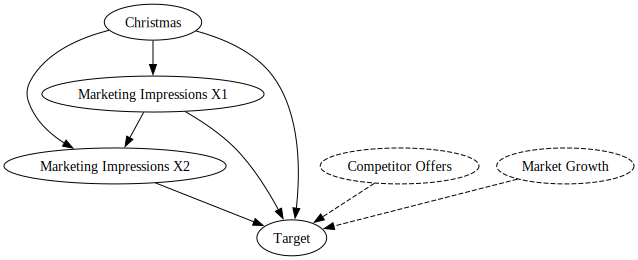

In [3]:
# Initialize a directed graph
dot = Digraph()

# Add nodes
dot.node('C', 'Christmas')
dot.node('X1', 'Marketing Impressions X1')
dot.node('X2', 'Marketing Impressions X2')
dot.node('I', 'Competitor Offers', style="dashed")
dot.node('G', 'Market Growth', style="dashed")
dot.node('T', 'Target')

# Add edges to represent the relationships
dot.edge('C', 'X1')
dot.edge('C', 'X2')

dot.edge('X1', 'X2')

## Variables that affect the target
dot.edge('C', 'T')
dot.edge('X1', 'T')
dot.edge('X2', 'T')
dot.edge('I', 'T', style="dashed")
dot.edge('G', 'T', style="dashed")

# Render the graph to SVG and display it inline
svg_str = dot.pipe(format='svg')
display(SVG(svg_str))

In [4]:
# date range
min_date = pd.to_datetime("2022-01-01")
max_date = pd.to_datetime("2024-11-06")
date_range = pd.date_range(start=min_date, end=max_date, freq="D")

df = pd.DataFrame(
    data={"date_week": date_range}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 1041


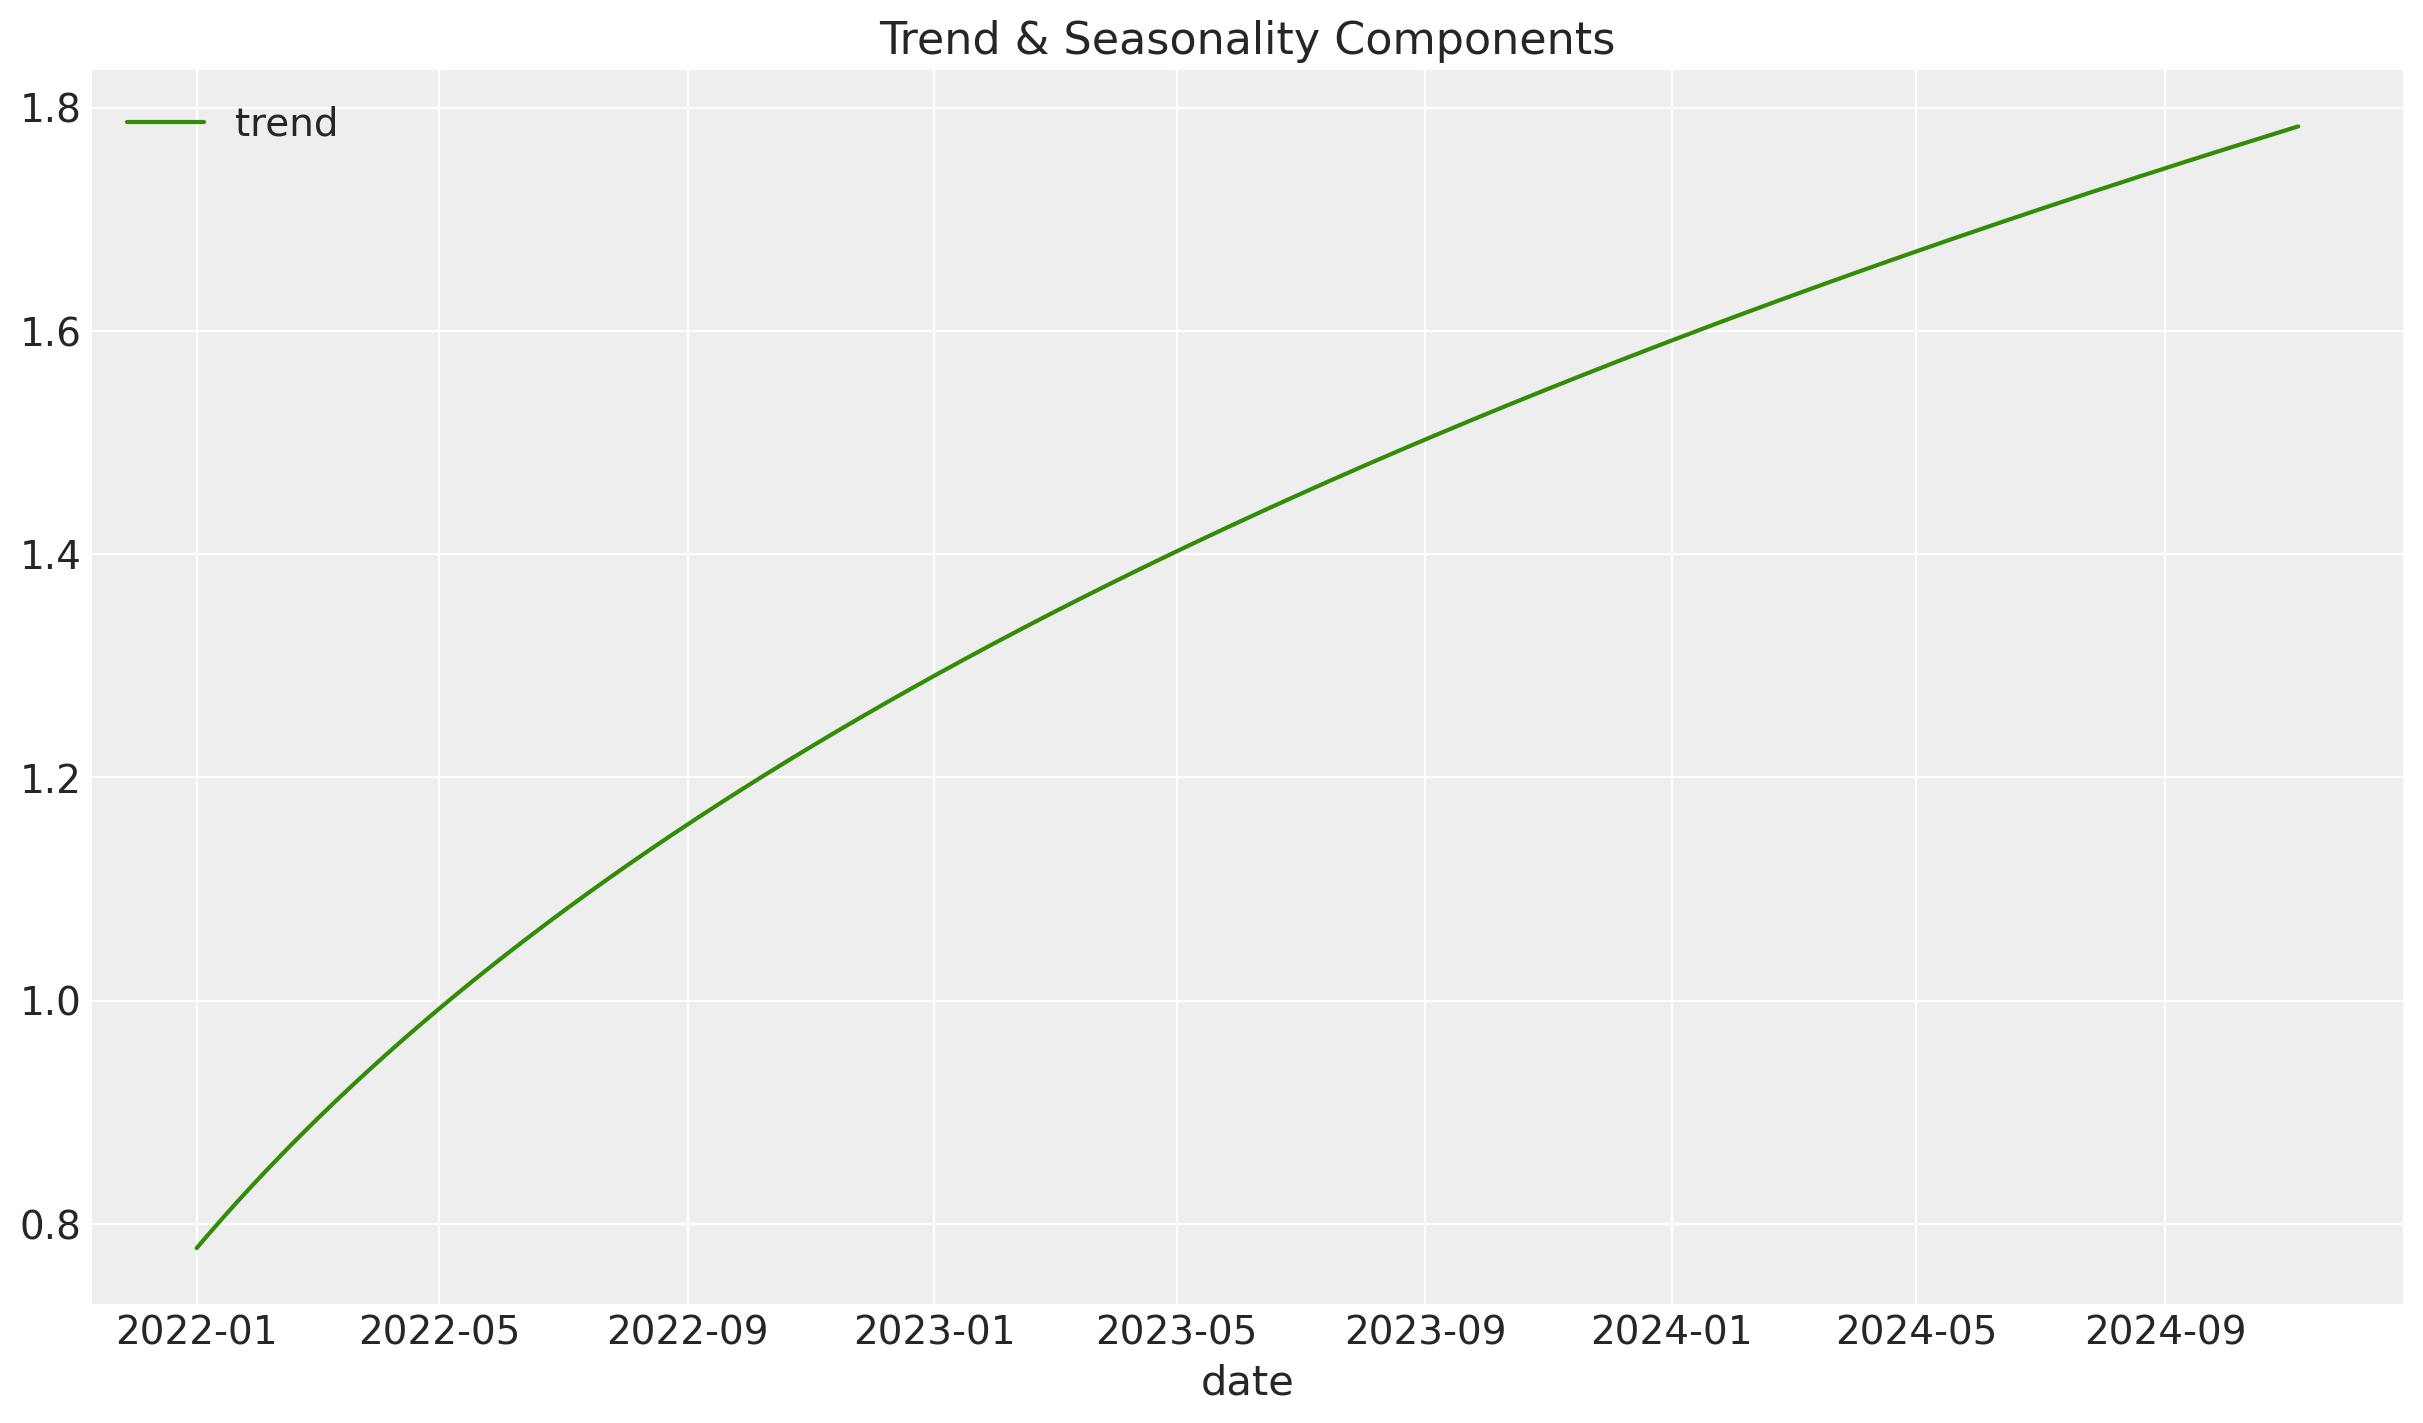

In [5]:
df["market_growth"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="market_growth", color="C2", label="trend", data=df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

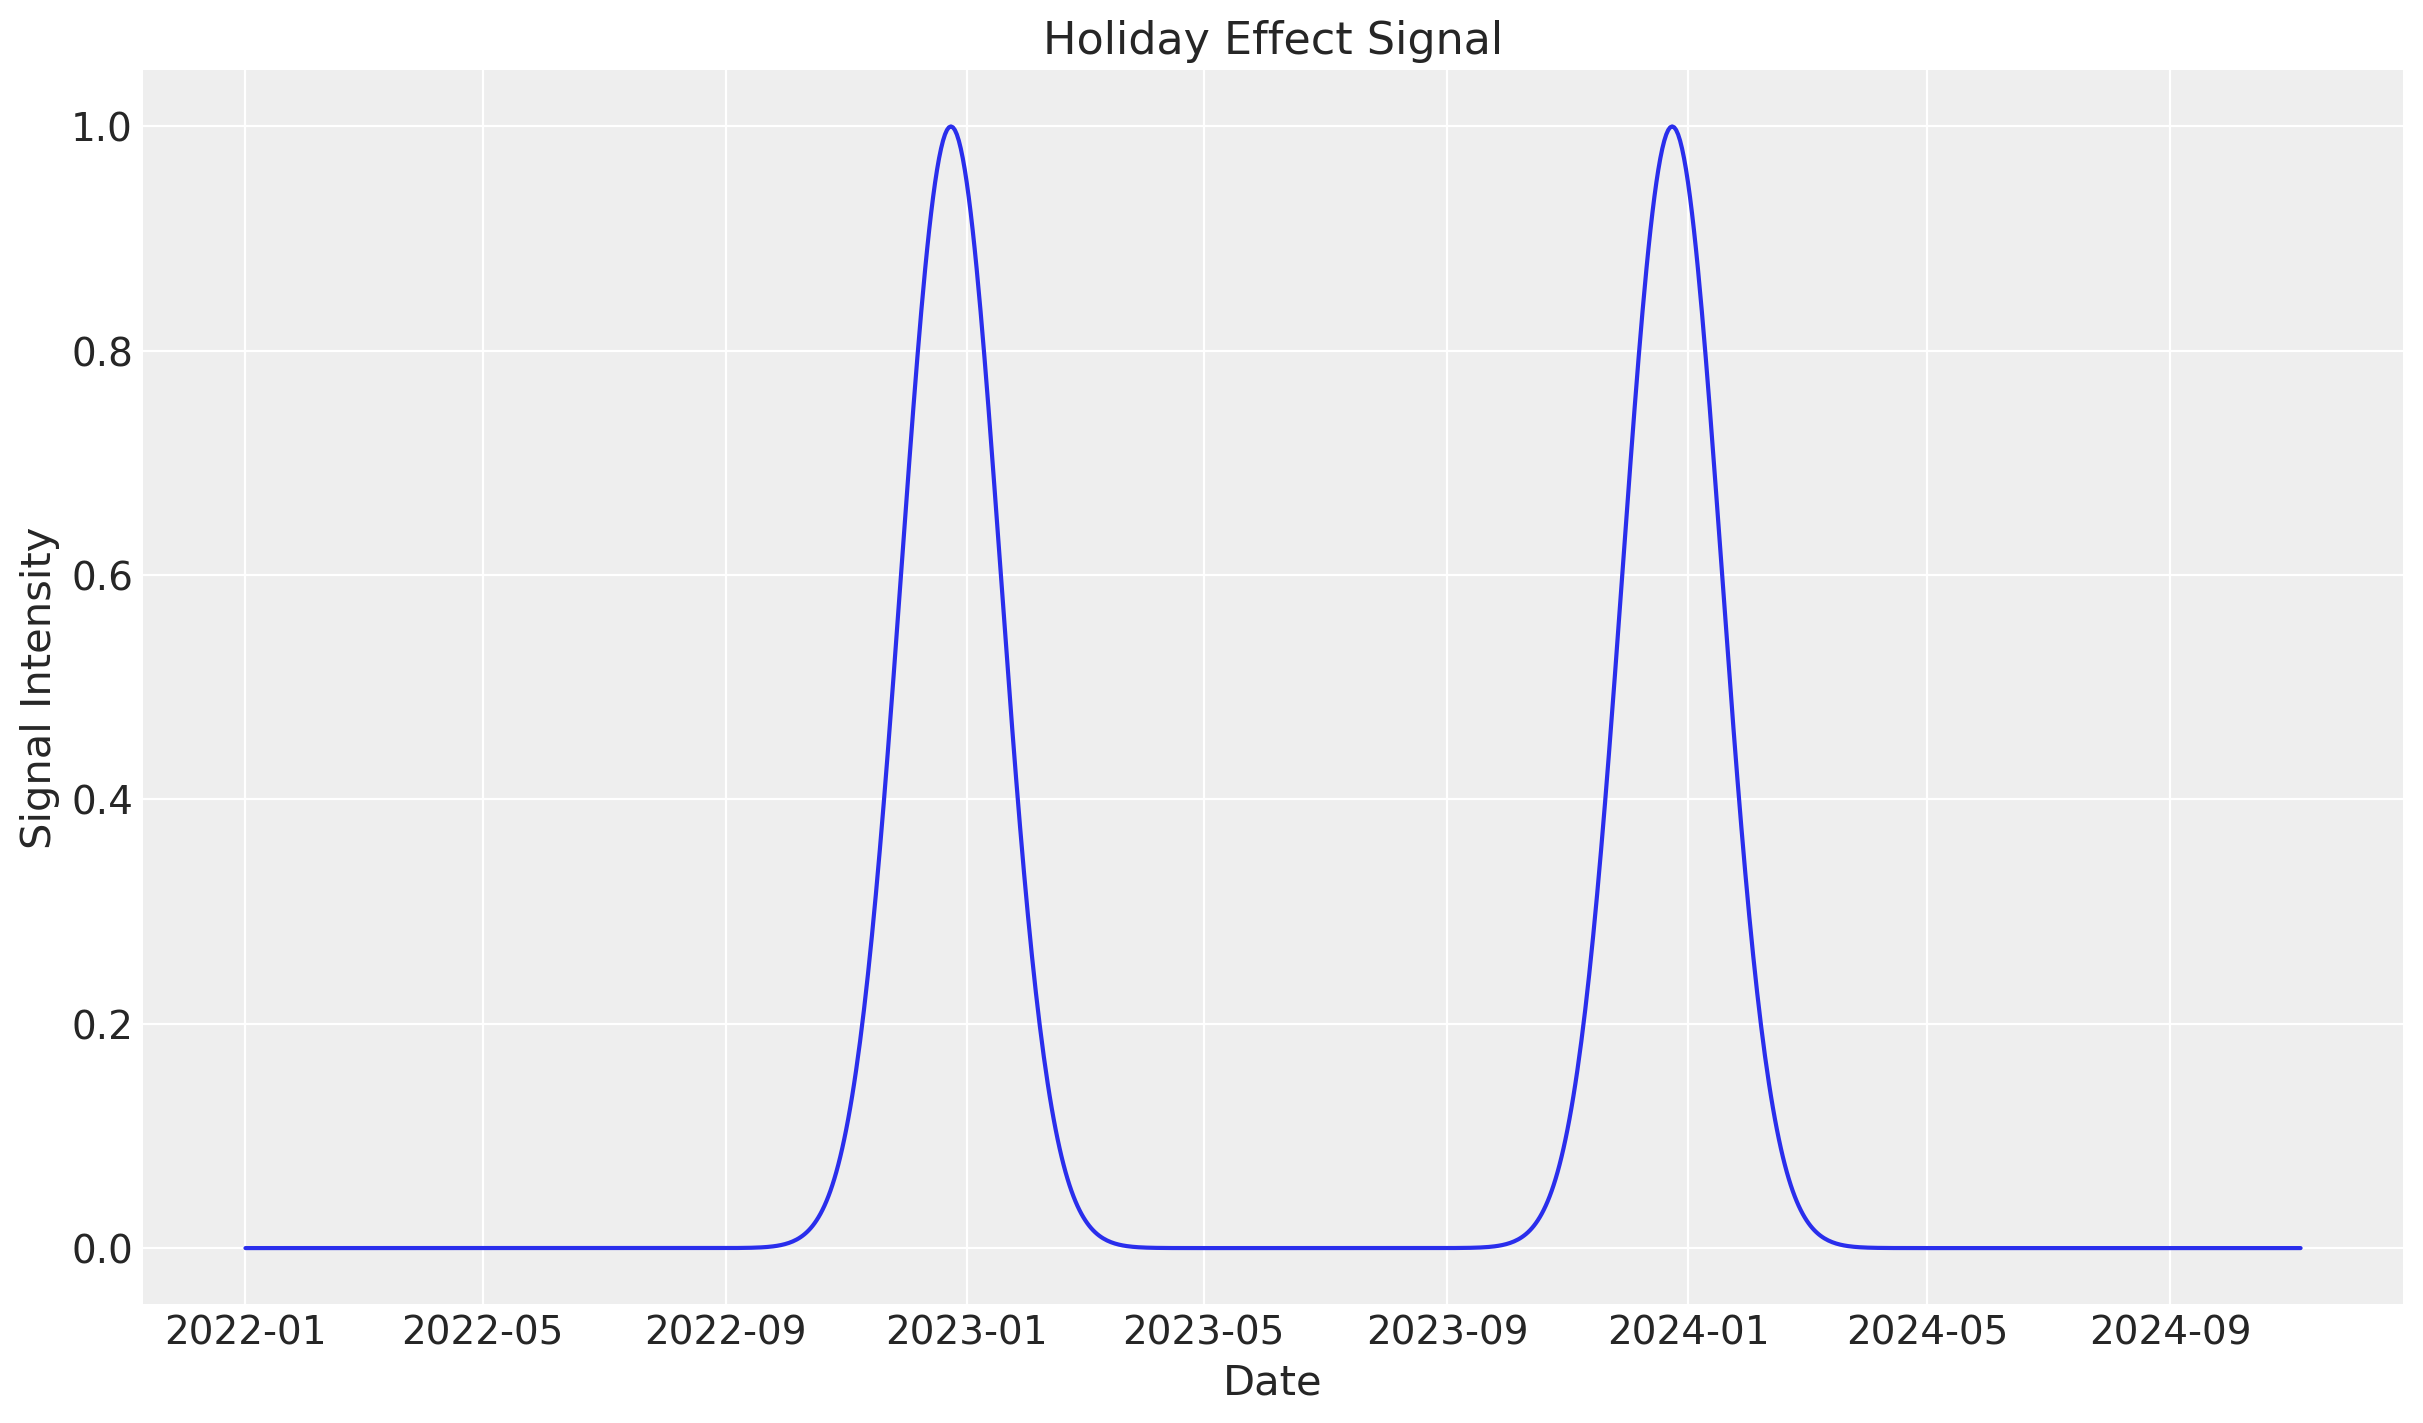

In [6]:
holiday_dates = ["24-12"]  # List of holidays as month-day strings
std_devs = [25]  # List of standard deviations for each holiday
holidays_coefficients = [2]

# Initialize the holiday effect array
holiday_signal = np.zeros(len(date_range))
holiday_contributions = np.zeros(len(date_range))

# Generate holiday signals
for holiday, std_dev, holiday_coef in zip(holiday_dates, std_devs, holidays_coefficients):
    # Find all occurrences of the holiday in the date range
    holiday_occurrences = date_range[date_range.strftime("%d-%m") == holiday]
    
    for occurrence in holiday_occurrences:
        # Calculate the time difference in days
        time_diff = (date_range - occurrence).days
        
        # Generate the Gaussian basis for the holiday
        _holiday_signal = np.exp(-0.5 * (time_diff / std_dev) ** 2)
        
        # Add the holiday signal to the holiday effect
        holiday_signal += _holiday_signal

        holiday_contributions += _holiday_signal * holiday_coef

df["holiday_signal"] = holiday_signal
df["holiday_contributions"] = holiday_contributions

# Plot the holiday effect
fig, ax = plt.subplots()
sns.lineplot(x=date_range, y=holiday_signal, ax=ax)
ax.set(title="Holiday Effect Signal", xlabel="Date", ylabel="Signal Intensity")
plt.show()

In [7]:
x1 = pz.Normal(mu=5, sigma=3).rvs(n, random_state=rng)
cofounder_effect_holiday_x1 = 2.5
df["x1"] = np.convolve(x1, np.ones(14)/14, mode='same') + (holiday_signal * cofounder_effect_holiday_x1) #+ pz.Normal(mu=0, sigma=0.05).rvs(n, random_state=rng)

x2 = pz.Normal(mu=5, sigma=2).rvs(n, random_state=rng)
cofounder_effect_holiday_x2 = 2.2
cofounder_effect_x1_x2 = 1.3
df["x2"] = np.convolve(x2, np.ones(18)/12, mode='same') + (holiday_signal * cofounder_effect_holiday_x2) + (df["x1"] * cofounder_effect_x1_x2) #+ pz.Normal(mu=0, sigma=0.05).rvs(n, random_state=rng)


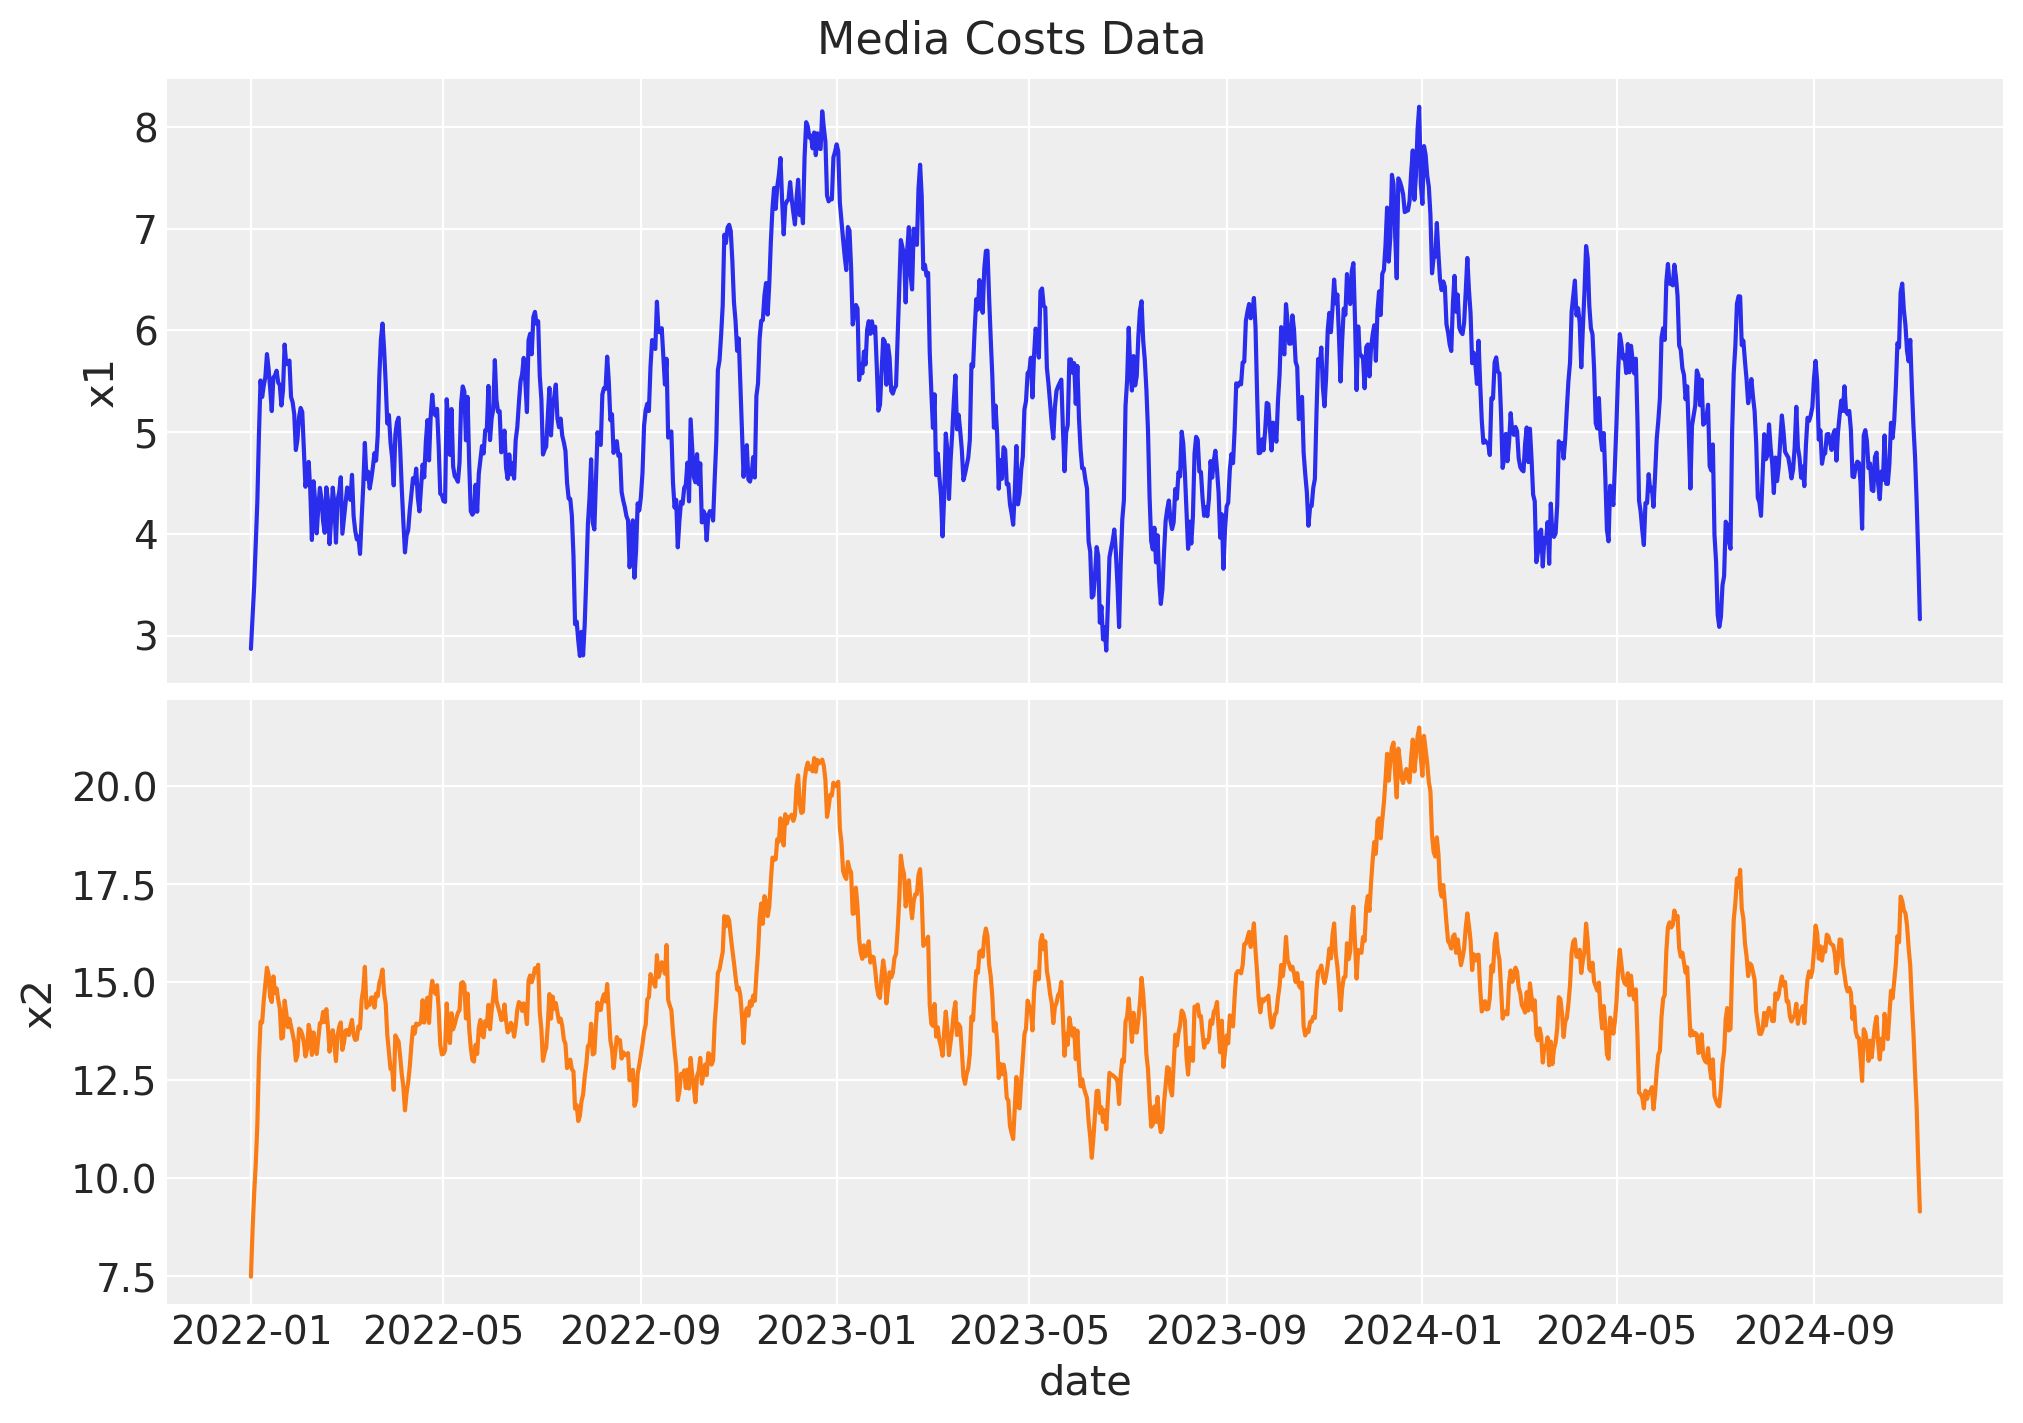

In [9]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

In [10]:
# apply geometric adstock transformation
alpha1: float = 0.6
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=24, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=24, normalize=True)
    .eval()
    .flatten()
)

# apply saturation transformation
lam1: float = 5.0
lam2: float = 9.0

alpha_mm1: float = 6
alpha_mm2: float = 12

df["x1_adstock_saturated"] = michaelis_menten(
    x=df["x1_adstock"].to_numpy(), lam=lam1, alpha=alpha_mm1
)

df["x2_adstock_saturated"] = michaelis_menten(
    x=df["x2_adstock"].to_numpy(), lam=lam2, alpha=alpha_mm2
)

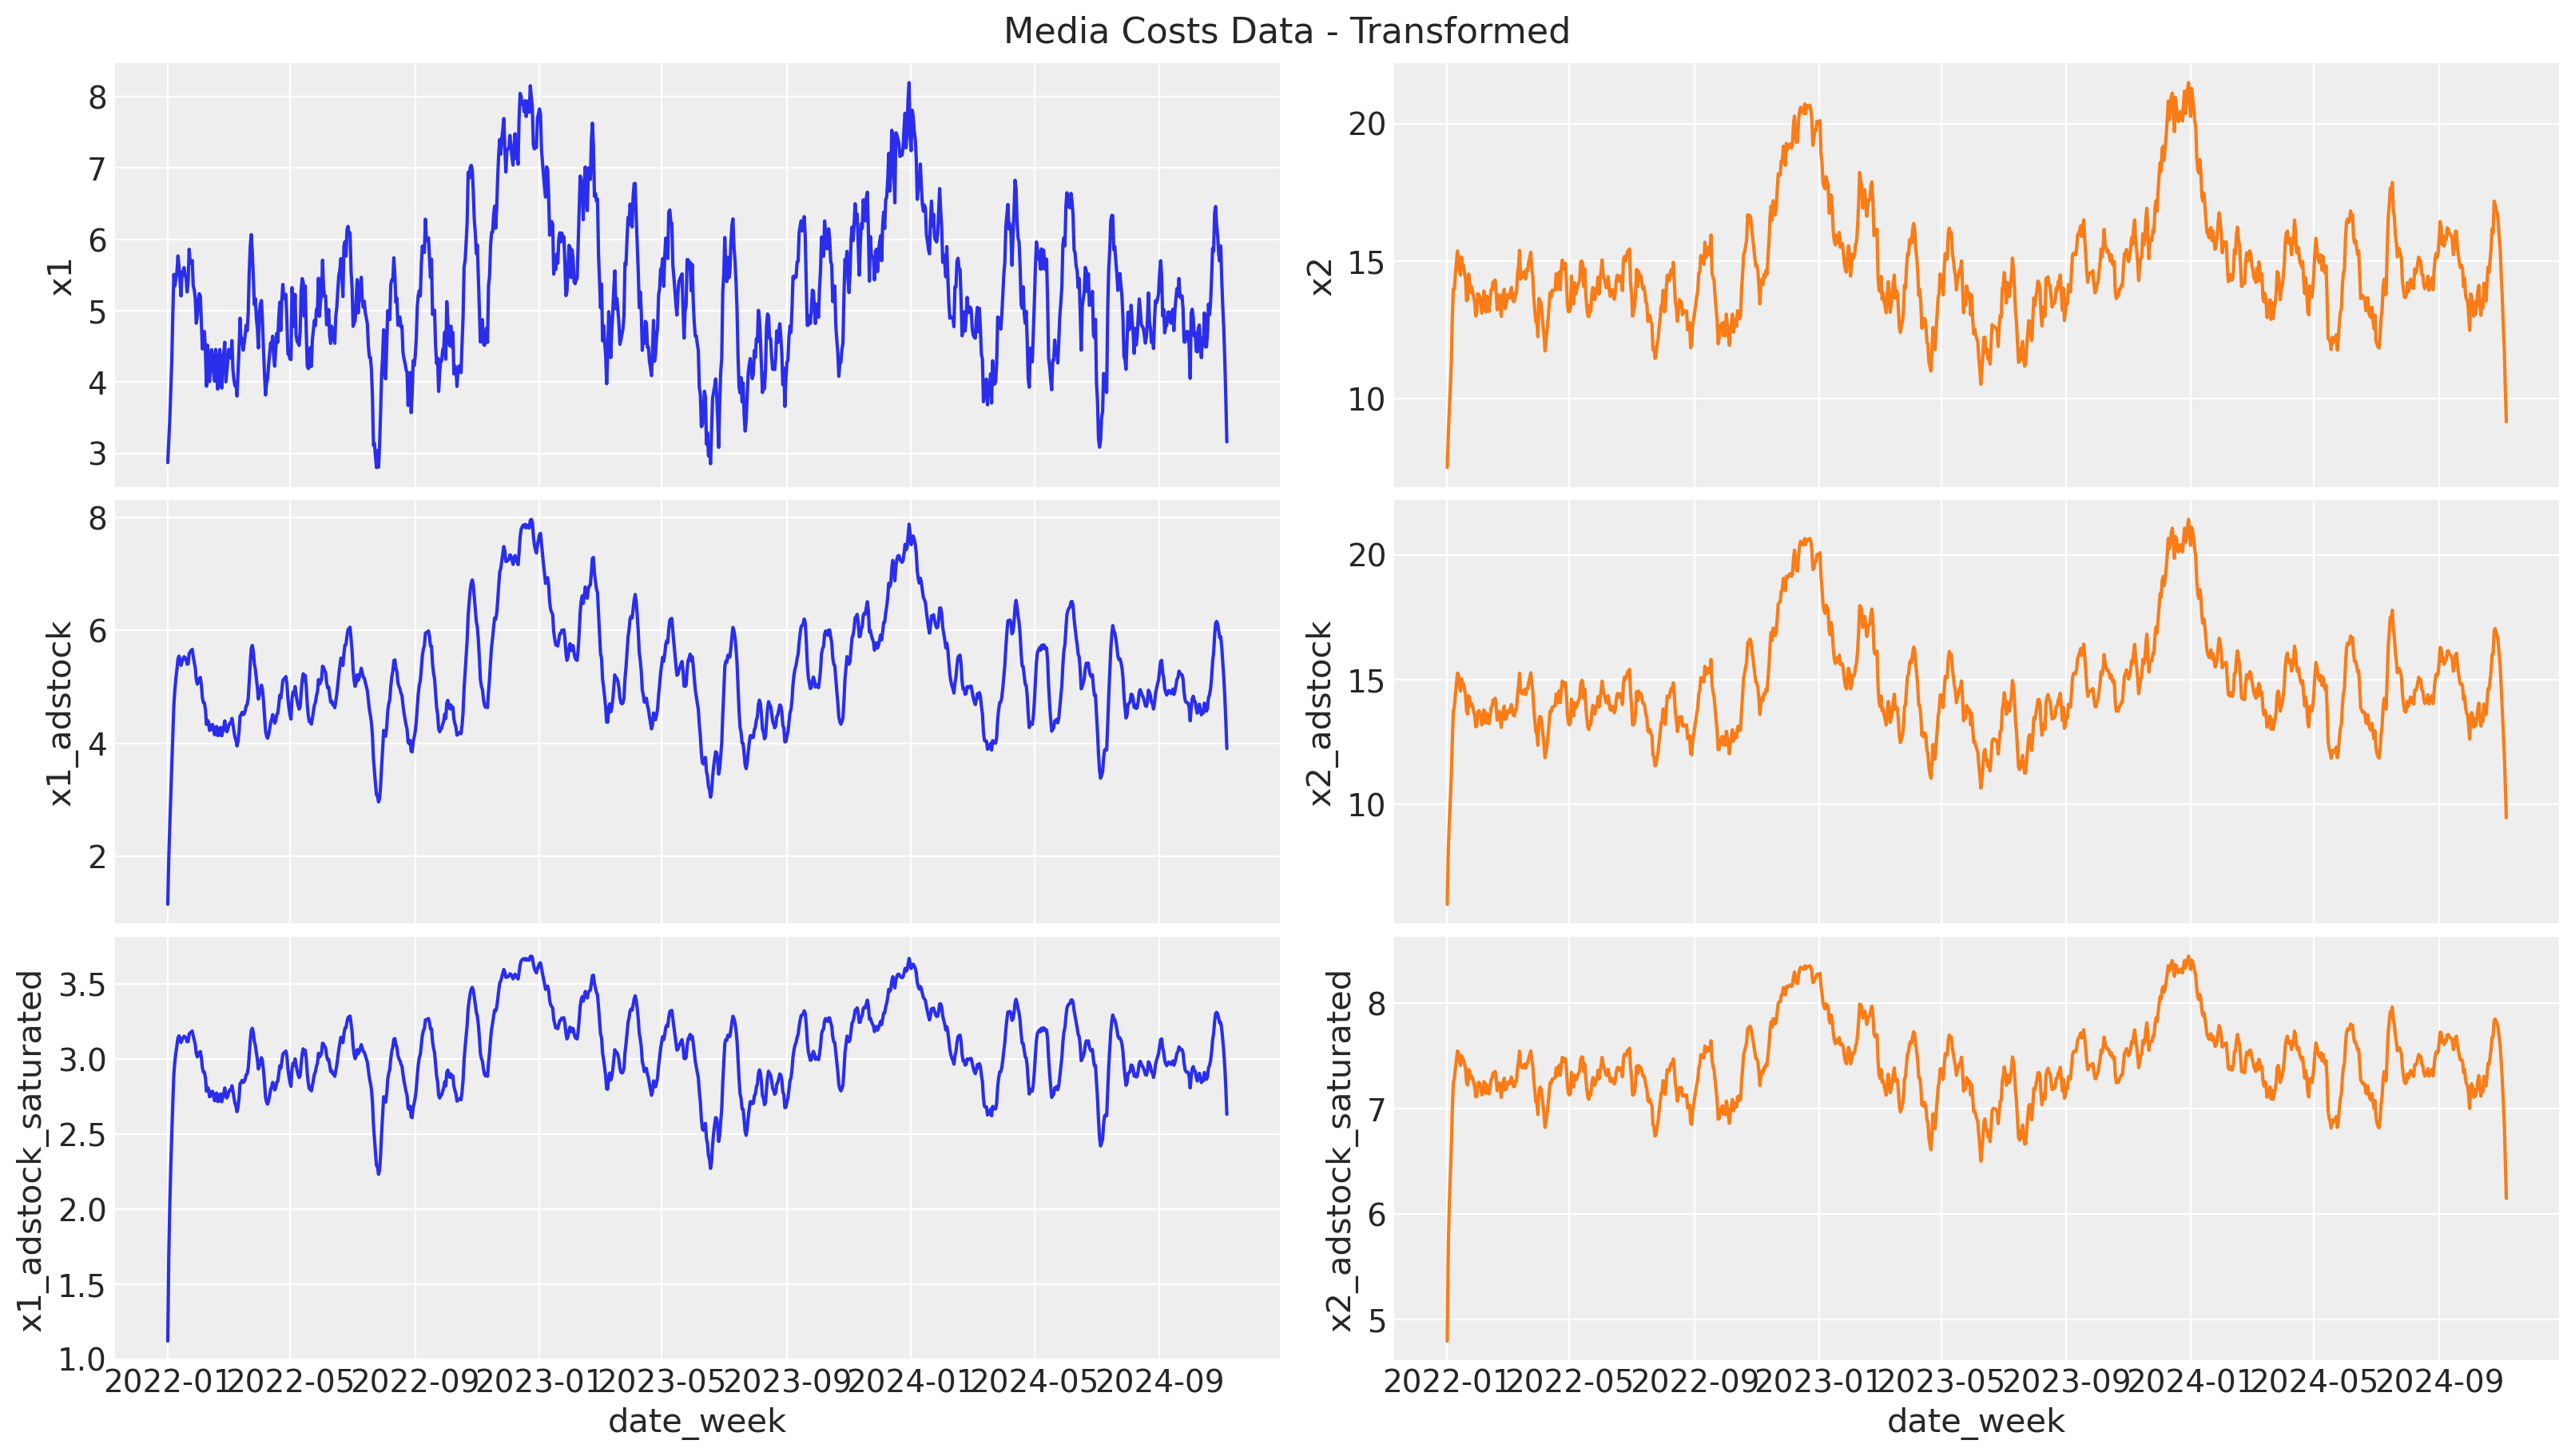

In [11]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

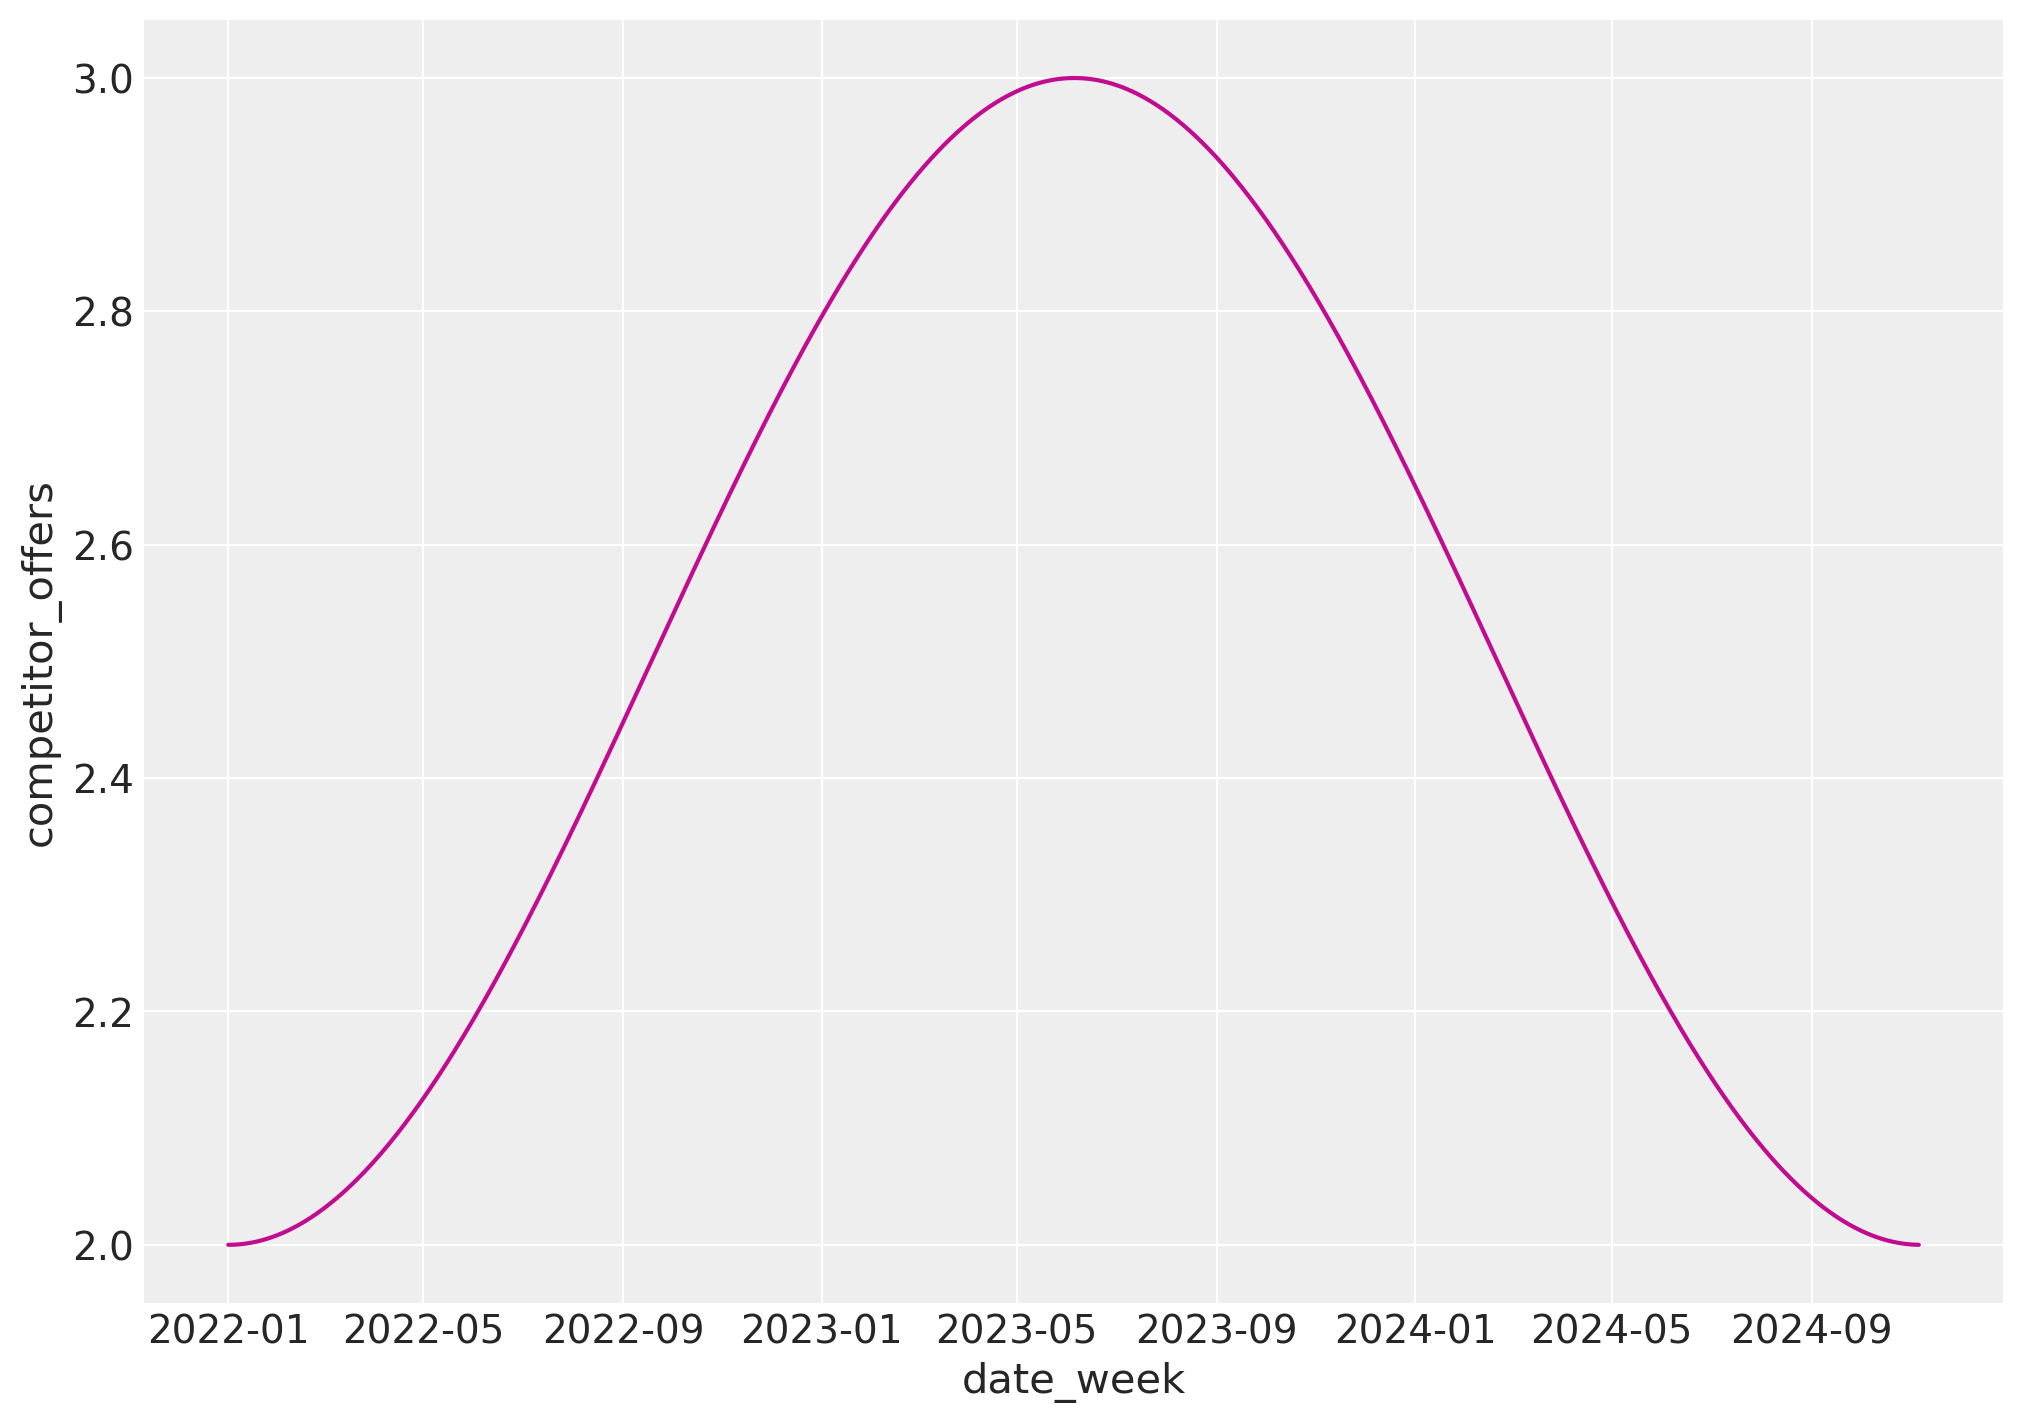

In [12]:
A = 0.5   # Amplitude
C = 2.5   # Center of the oscillation
omega = np.pi / (n / 2)  # Adjust omega to achieve a single peak (inverted "U") over the entire period

df["competitor_offers"] = -A * np.cos(omega * df.index) + C

#plot the competition price and competitor_offers
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(10, 7), sharex=True, layout="constrained"
)
sns.lineplot(x="date_week", y="competitor_offers", data=df, color="C3", ax=ax);

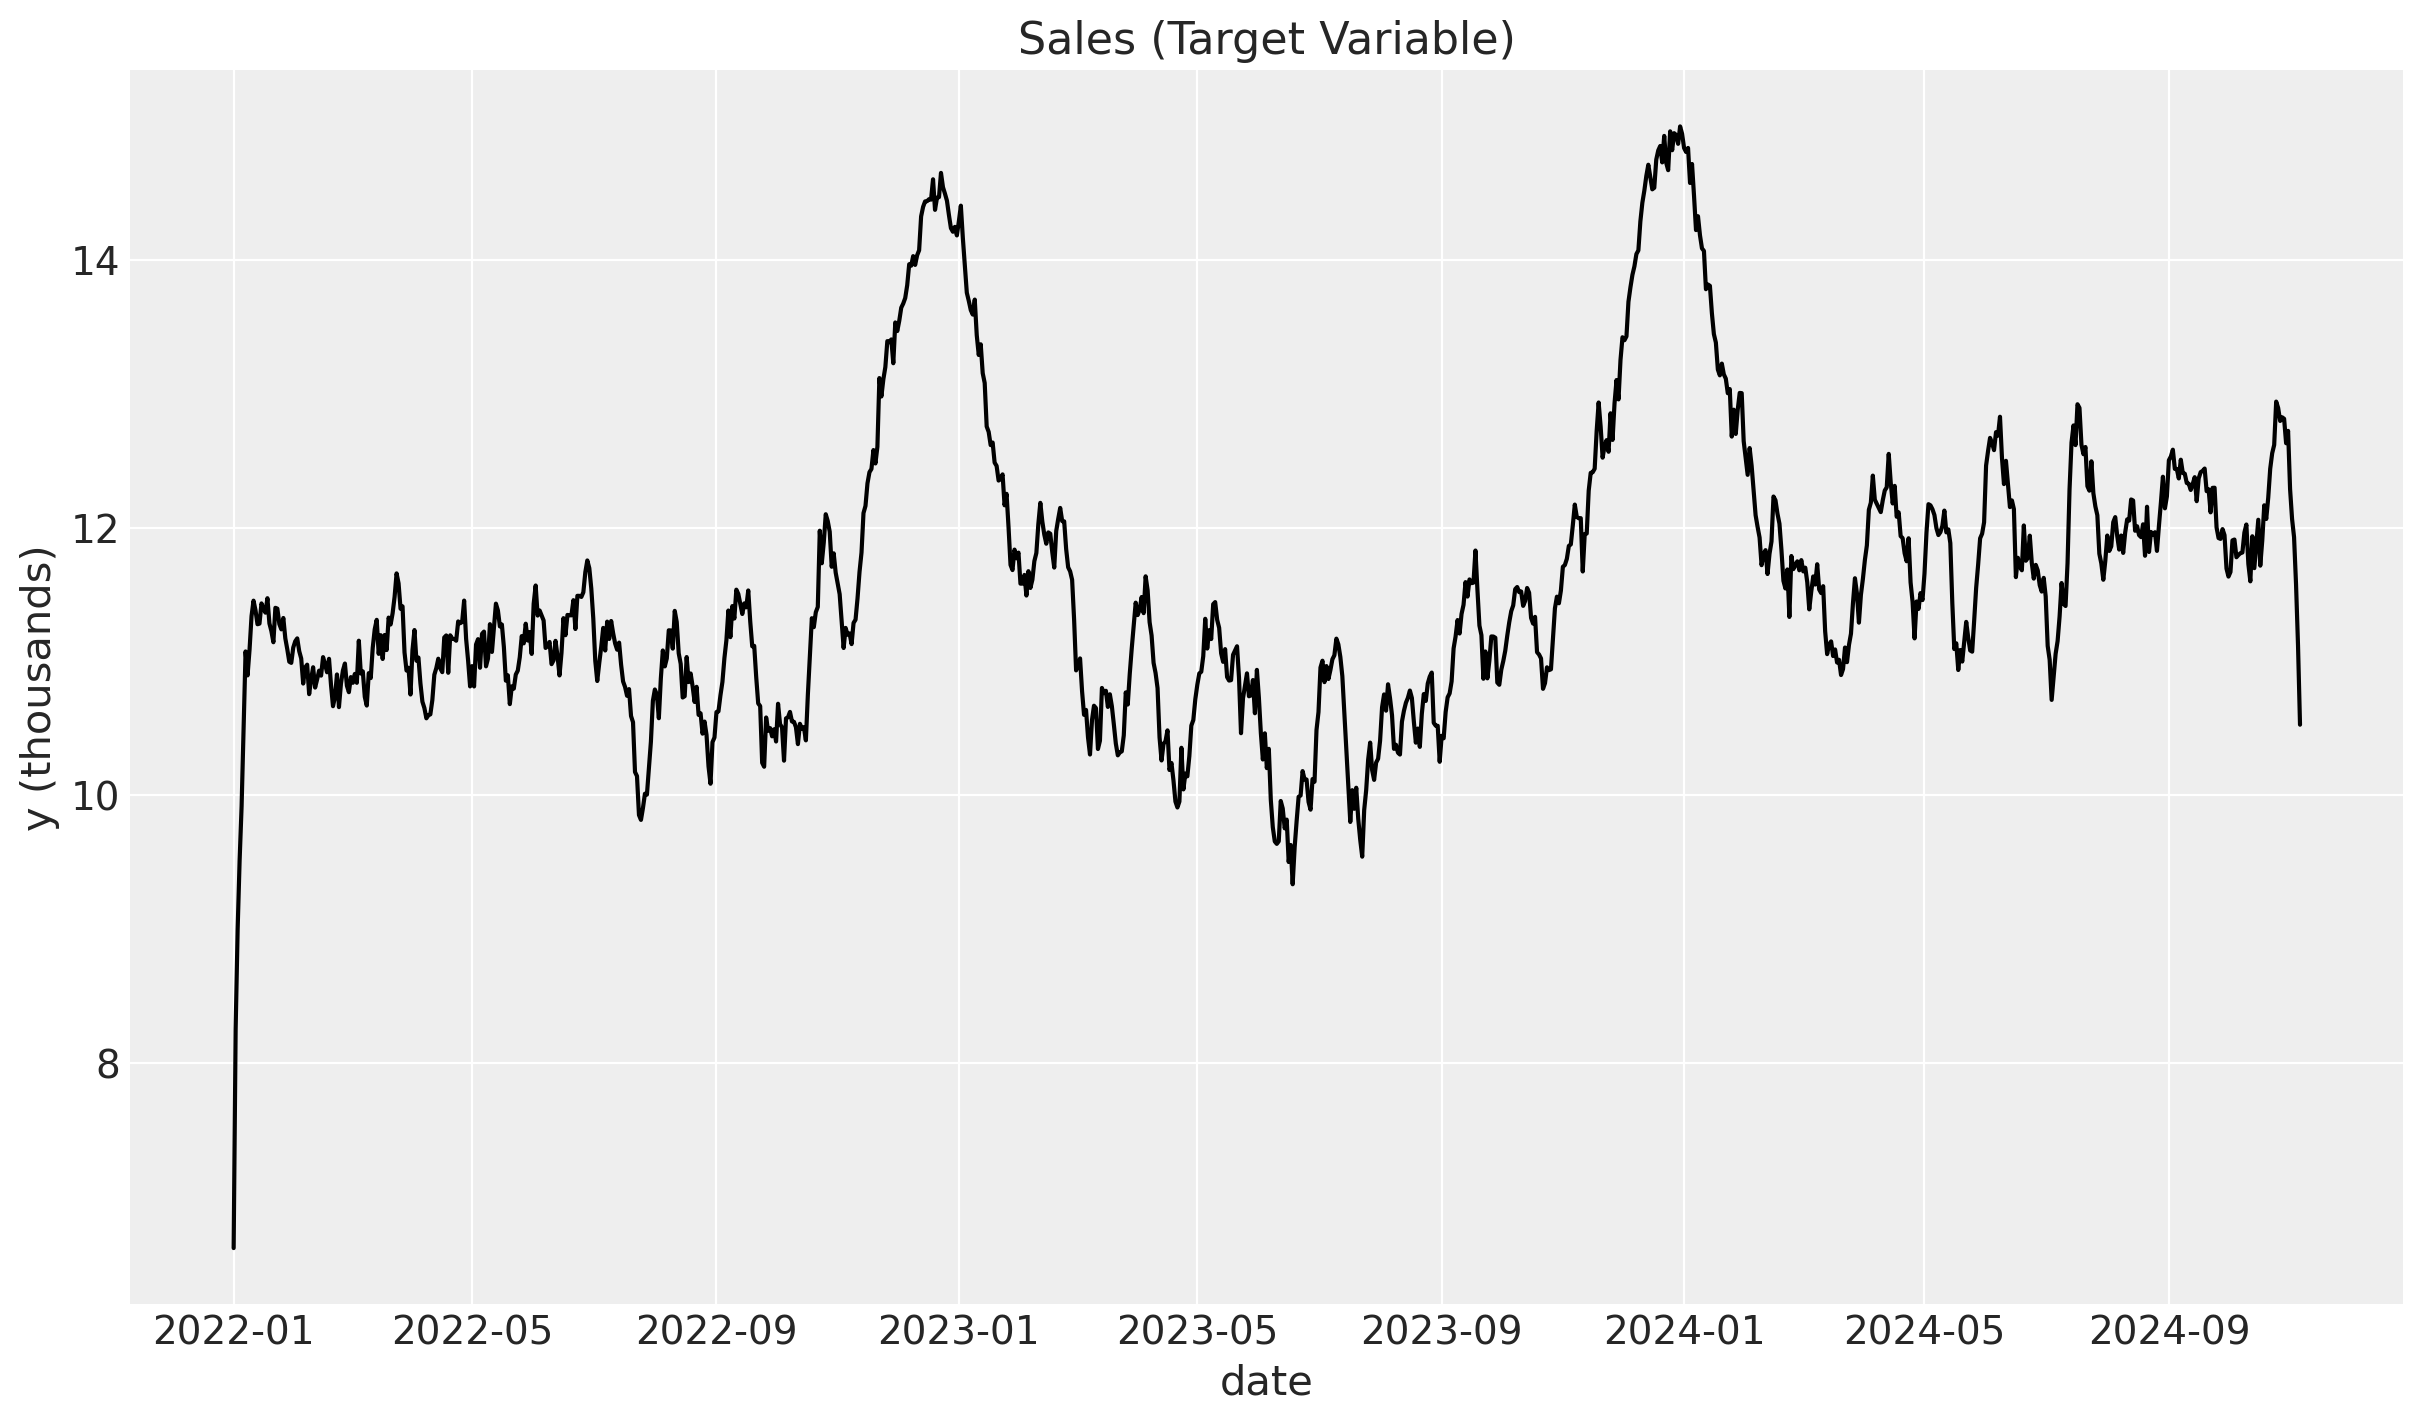

In [14]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.08, size=n)

df["y"] = (
    df["intercept"]
    + df["market_growth"] #implicit coef 1
    - df["competitor_offers"] #explicit coef -1
    + df["holiday_contributions"]
    + df["x1_adstock_saturated"]
    + df["x2_adstock_saturated"]
    + df["epsilon"] # Noise
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

In [15]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
]

data = df[columns_to_keep].copy()

data.head()

date_week         y        x1         x2
0 2022-01-01  6.615062  2.869349   7.491001
1 2022-01-02  8.249814  3.169818   8.645741
2 2022-01-03  8.992971  3.479087   9.603749
3 2022-01-04  9.511094  3.888128  10.347369
4 2022-01-05  9.917173  4.314848  11.352003

In [16]:
X = data.drop("y", axis=1)
y = data["y"]

In [17]:
# sampling options for PyMC
sample_kwargs = {"draws": 500, "chains": 4, "nuts_sampler":"numpyro"}

In [18]:
naive_mmm = MMM(
    sampler_config=sample_kwargs,
    date_column="date_week",
    adstock=GeometricAdstock(l_max=24),
    saturation=MichaelisMentenSaturation(),
    channel_columns=["x1", "x2"],
)

Sampling: [adstock_alpha, intercept, saturation_alpha, saturation_lam, y, y_sigma]


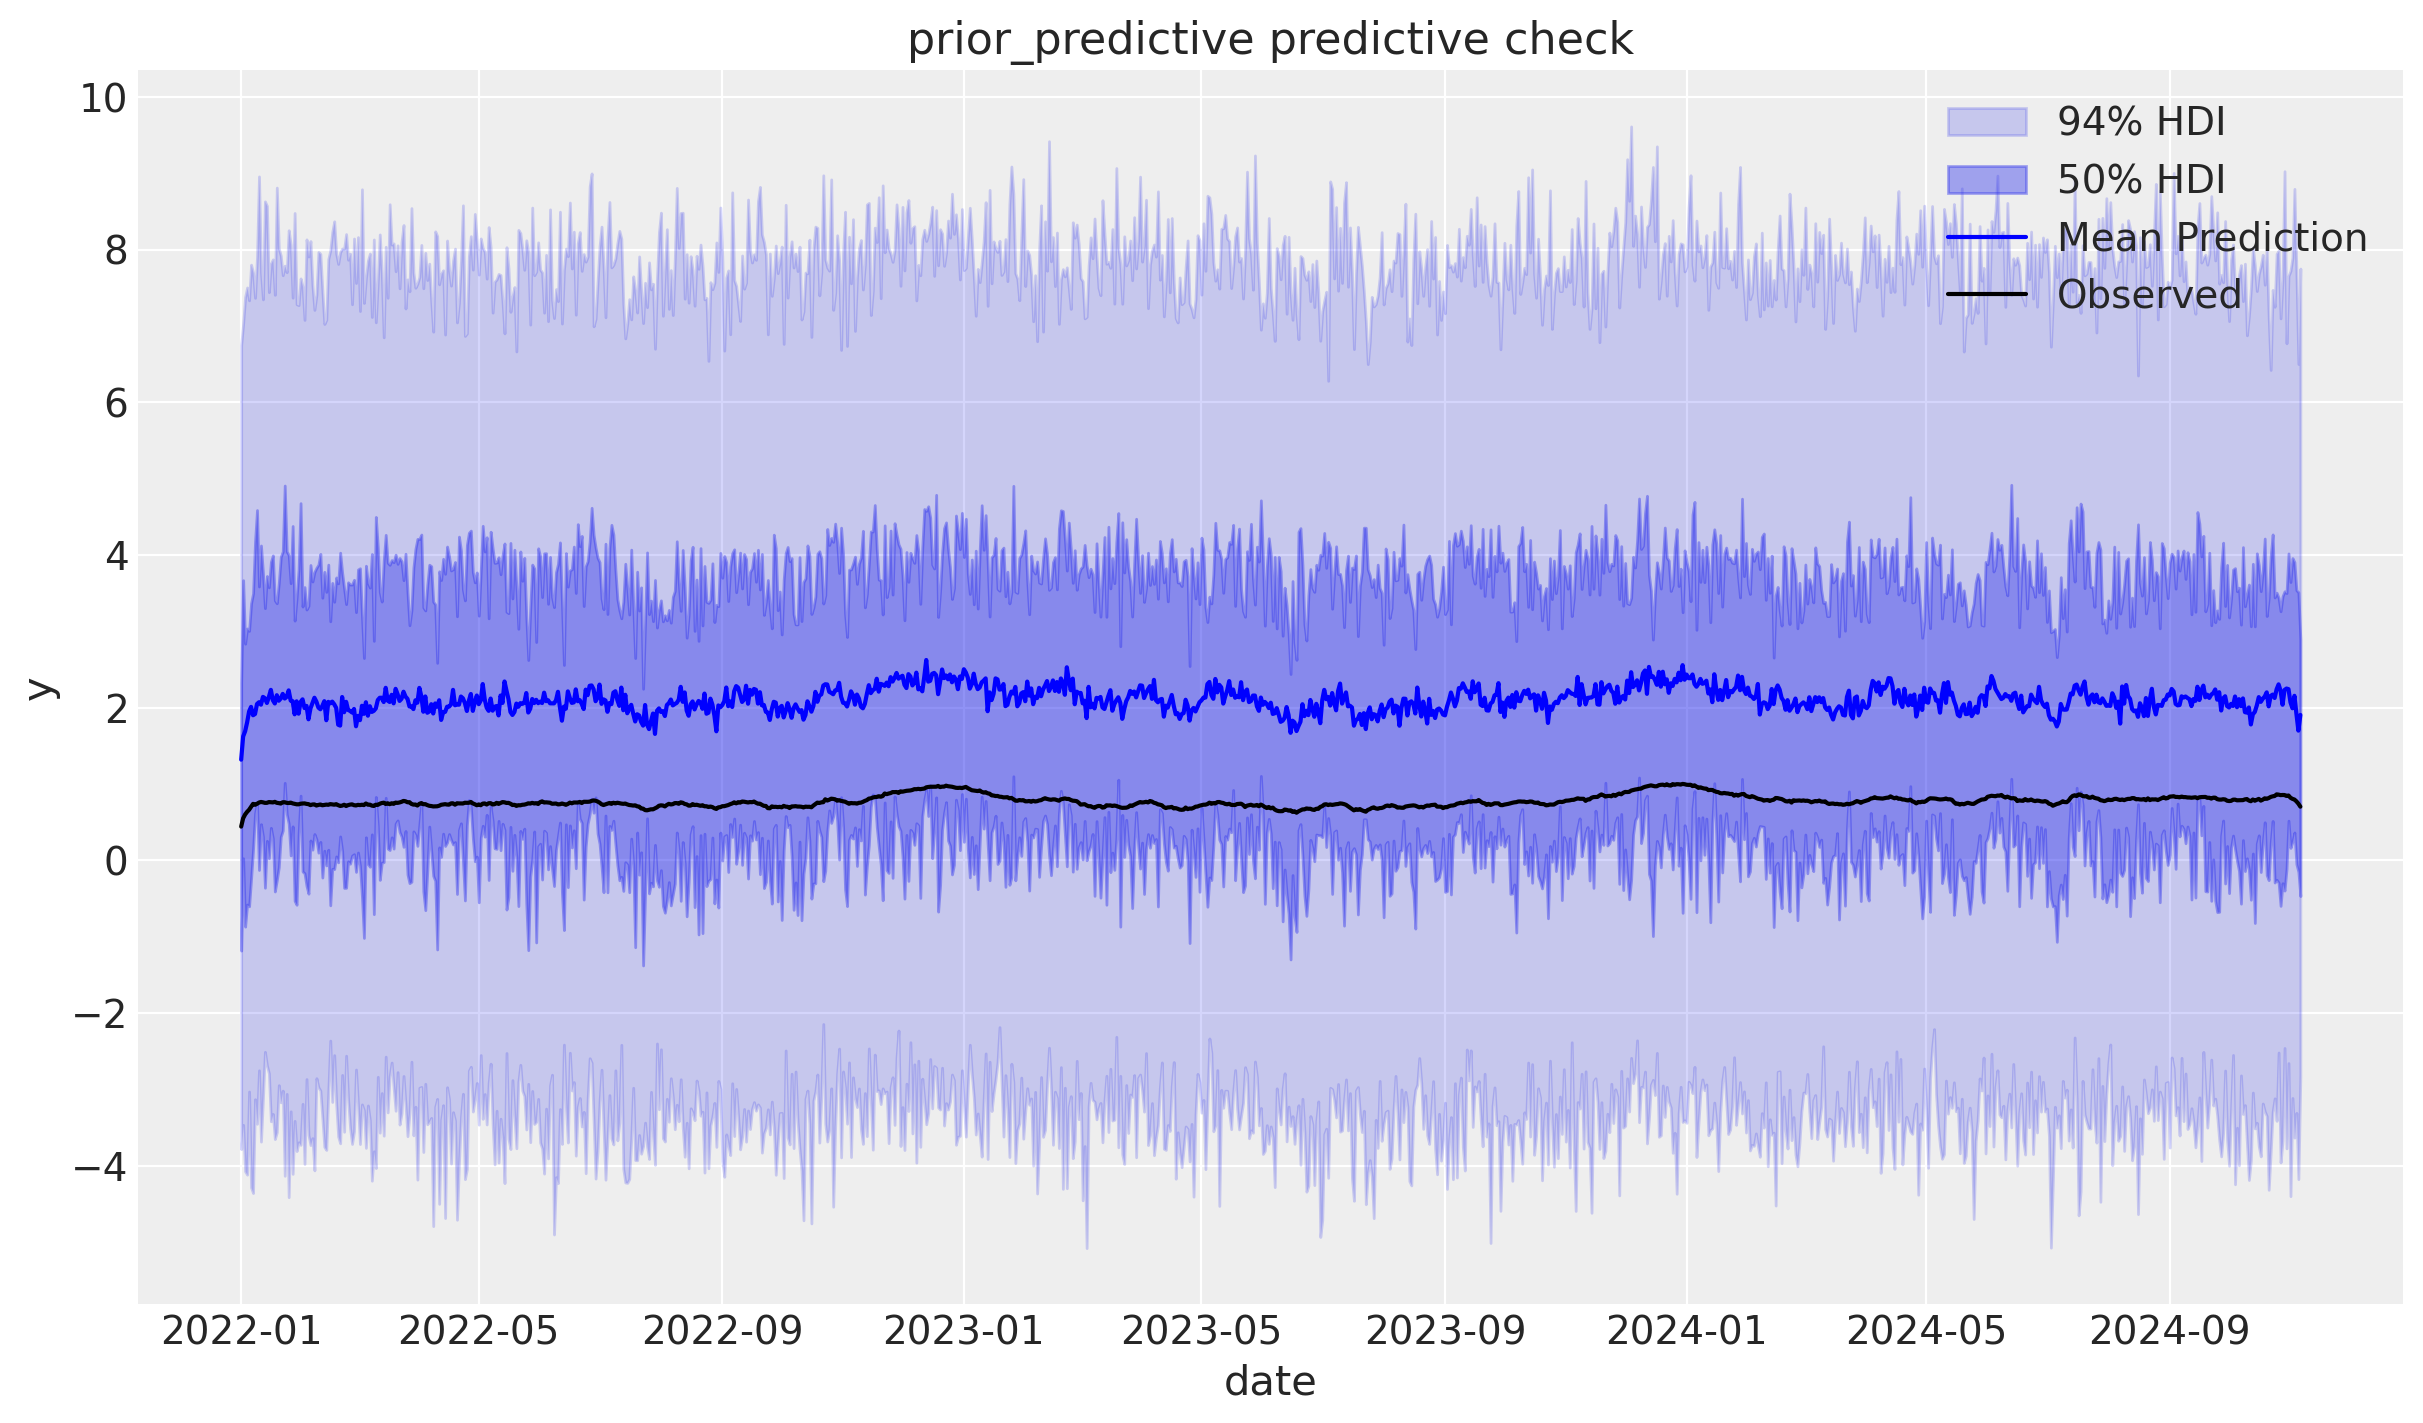

In [19]:
# Generate prior predictive samples
naive_mmm.sample_prior_predictive(X, y, samples=500)
naive_mmm.plot_prior_predictive();

In [20]:
# sampling options for PyMC
naive_mmm.fit(X=X, y=y, target_accept=0.85, random_seed=rng)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

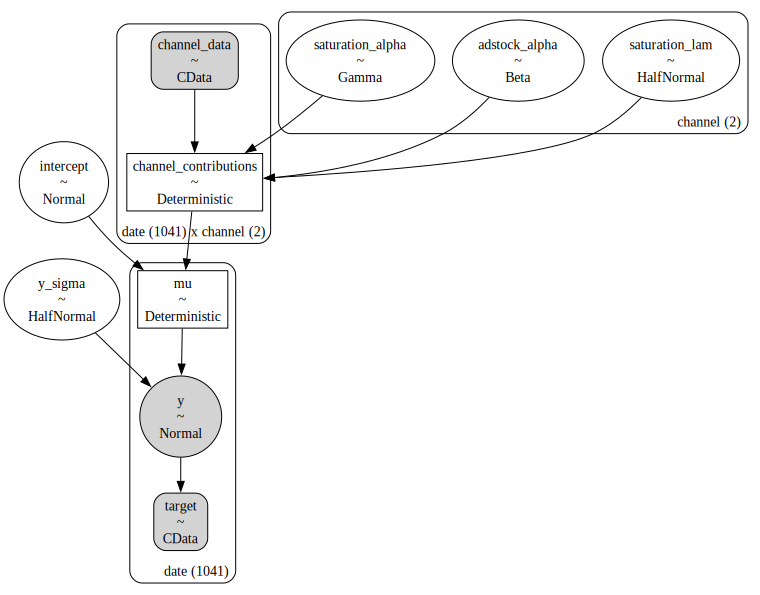

In [21]:
pm.model_to_graphviz(model=naive_mmm.model)

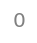

In [22]:
# Number of diverging samples
naive_mmm.idata["sample_stats"]["diverging"].sum().item()

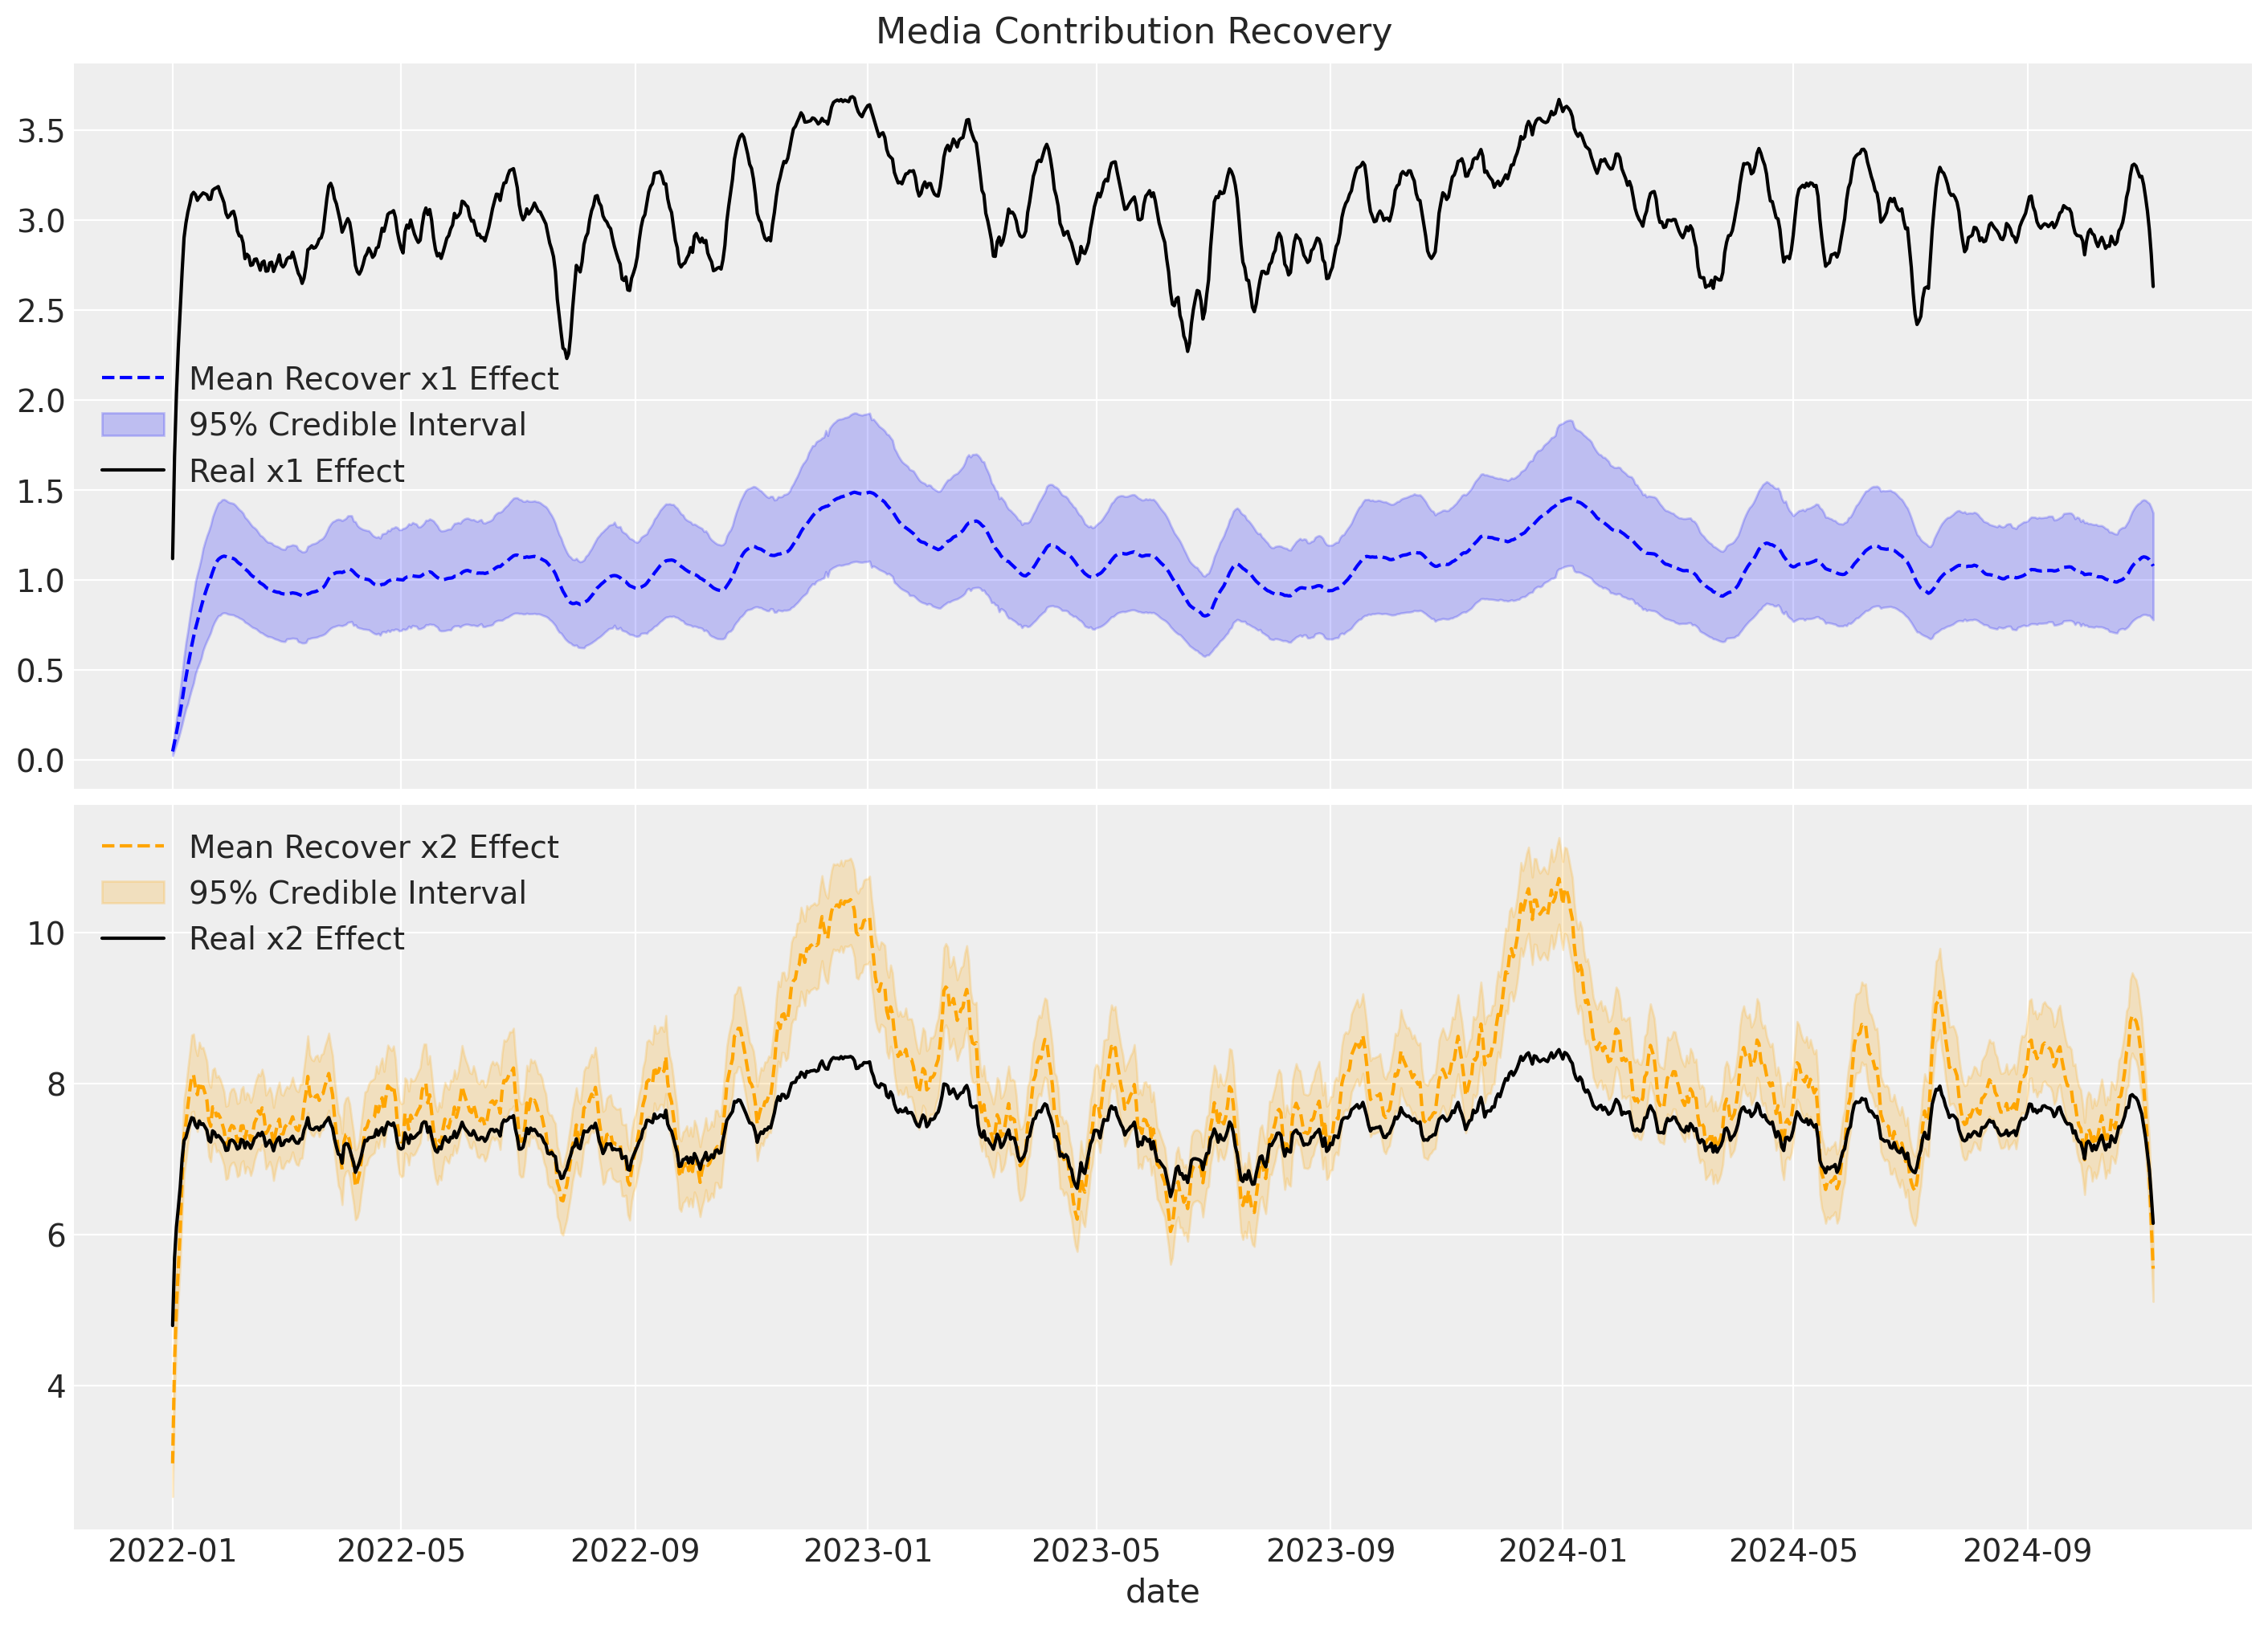

In [23]:
initial_model_recover_effect = az.hdi(naive_mmm.fit_result["channel_contributions"], hdi_prob=0.95) * naive_mmm.target_transformer["scaler"].scale_.item()

fig, ax = plt.subplots(2,1, figsize=(14, 10), sharex=True)
# facebook
ax[0].plot(
    date_range,
    naive_mmm.fit_result.channel_contributions.sel(channel="x1").mean(dim=["chain","draw"]) * naive_mmm.target_transformer["scaler"].scale_.item(),
    label="Mean Recover x1 Effect", linestyle="--", color="blue"
)
ax[0].fill_between(
    date_range,
    initial_model_recover_effect.channel_contributions.isel(hdi=0).sel(channel="x1"),
    initial_model_recover_effect.channel_contributions.isel(hdi=1).sel(channel="x1"),
    alpha=0.2, label="95% Credible Interval", color="blue"
)
ax[0].plot(date_range,df["x1_adstock_saturated"], label="Real x1 Effect", color="black")

# google
ax[1].plot(
    date_range,
    naive_mmm.fit_result.channel_contributions.sel(channel="x2").mean(dim=["chain","draw"]) * naive_mmm.target_transformer["scaler"].scale_.item(),
    label="Mean Recover x2 Effect", linestyle="--", color="orange"
)
ax[1].fill_between(
    date_range,
    initial_model_recover_effect.channel_contributions.isel(hdi=0).sel(channel="x2"),
    initial_model_recover_effect.channel_contributions.isel(hdi=1).sel(channel="x2"),
    alpha=0.2, label="95% Credible Interval", color="orange"
)
ax[1].plot(date_range, df["x2_adstock_saturated"], label="Real x2 Effect", color="black")

# formatting
ax[0].legend()
ax[1].legend()

plt.grid(True)
ax[1].set(xlabel="date")
fig.suptitle("Media Contribution Recovery", fontsize=16)
plt.show()

In [24]:
dag_str = """
digraph {
    x1 -> y;
    x1 -> x2;
    x2 -> y;
    holiday_signal -> y;
    holiday_signal -> x1;
    holiday_signal -> x2;
}
"""

In [25]:
data["holiday_signal"] = holiday_signal
data.head()

date_week         y        x1         x2  holiday_signal
0 2022-01-01  6.615062  2.869349   7.491001    5.244234e-45
1 2022-01-02  8.249814  3.169818   8.645741    9.276916e-45
2 2022-01-03  8.992971  3.479087   9.603749    1.638439e-44
3 2022-01-04  9.511094  3.888128  10.347369    2.889097e-44
4 2022-01-05  9.917173  4.314848  11.352003    5.086267e-44

In [26]:
initial_causal_mmm = MMM(
    sampler_config=sample_kwargs,
    date_column="date_week",
    outcome_node="y",
    adstock=GeometricAdstock(l_max=24),
    saturation=MichaelisMentenSaturation(),
    channel_columns=["x1", "x2"],
    control_columns=["holiday_signal"],
    dag=dag_str,
)

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/pydantic/_internal/_validate_call.py:96: UserWarning: No treatment nodes provided. Using channel columns as treatment nodes.
  res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/dowhy/causal_model.py:582: UserWarning: 4 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [27]:
initial_causal_mmm.adjustment_set, initial_causal_mmm.minimal_adjustment_set

(['holiday_signal'], ['holiday_signal', 'x1', 'x2'])

In [29]:
X = data.drop("y", axis=1)
y = data["y"]

In [30]:
initial_causal_mmm.fit(X=X, y=y, target_accept=0.85, random_seed=rng)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

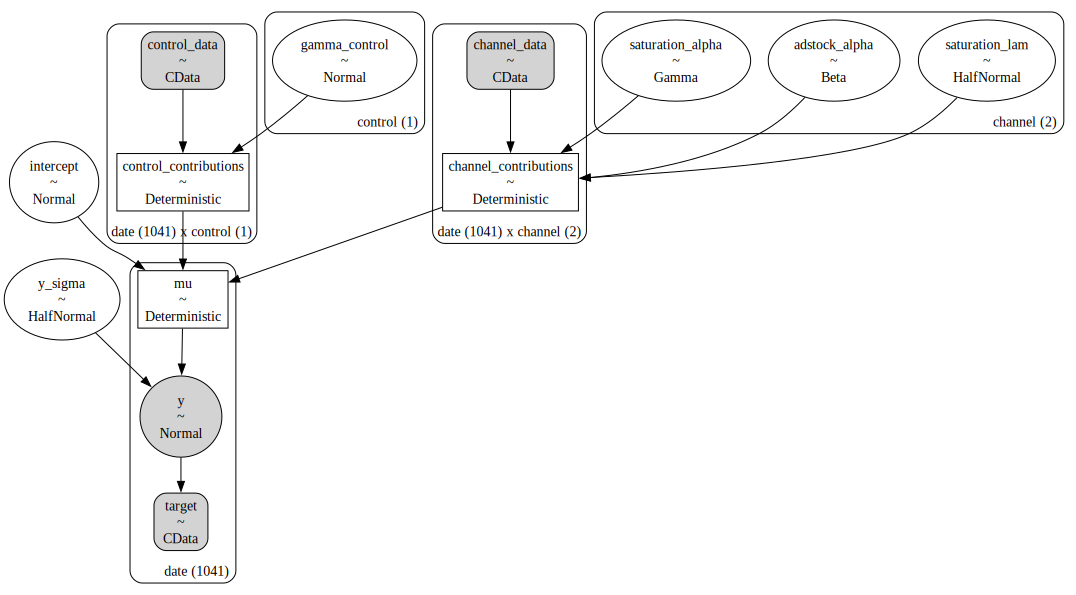

In [31]:
pm.model_to_graphviz(model=initial_causal_mmm.model)

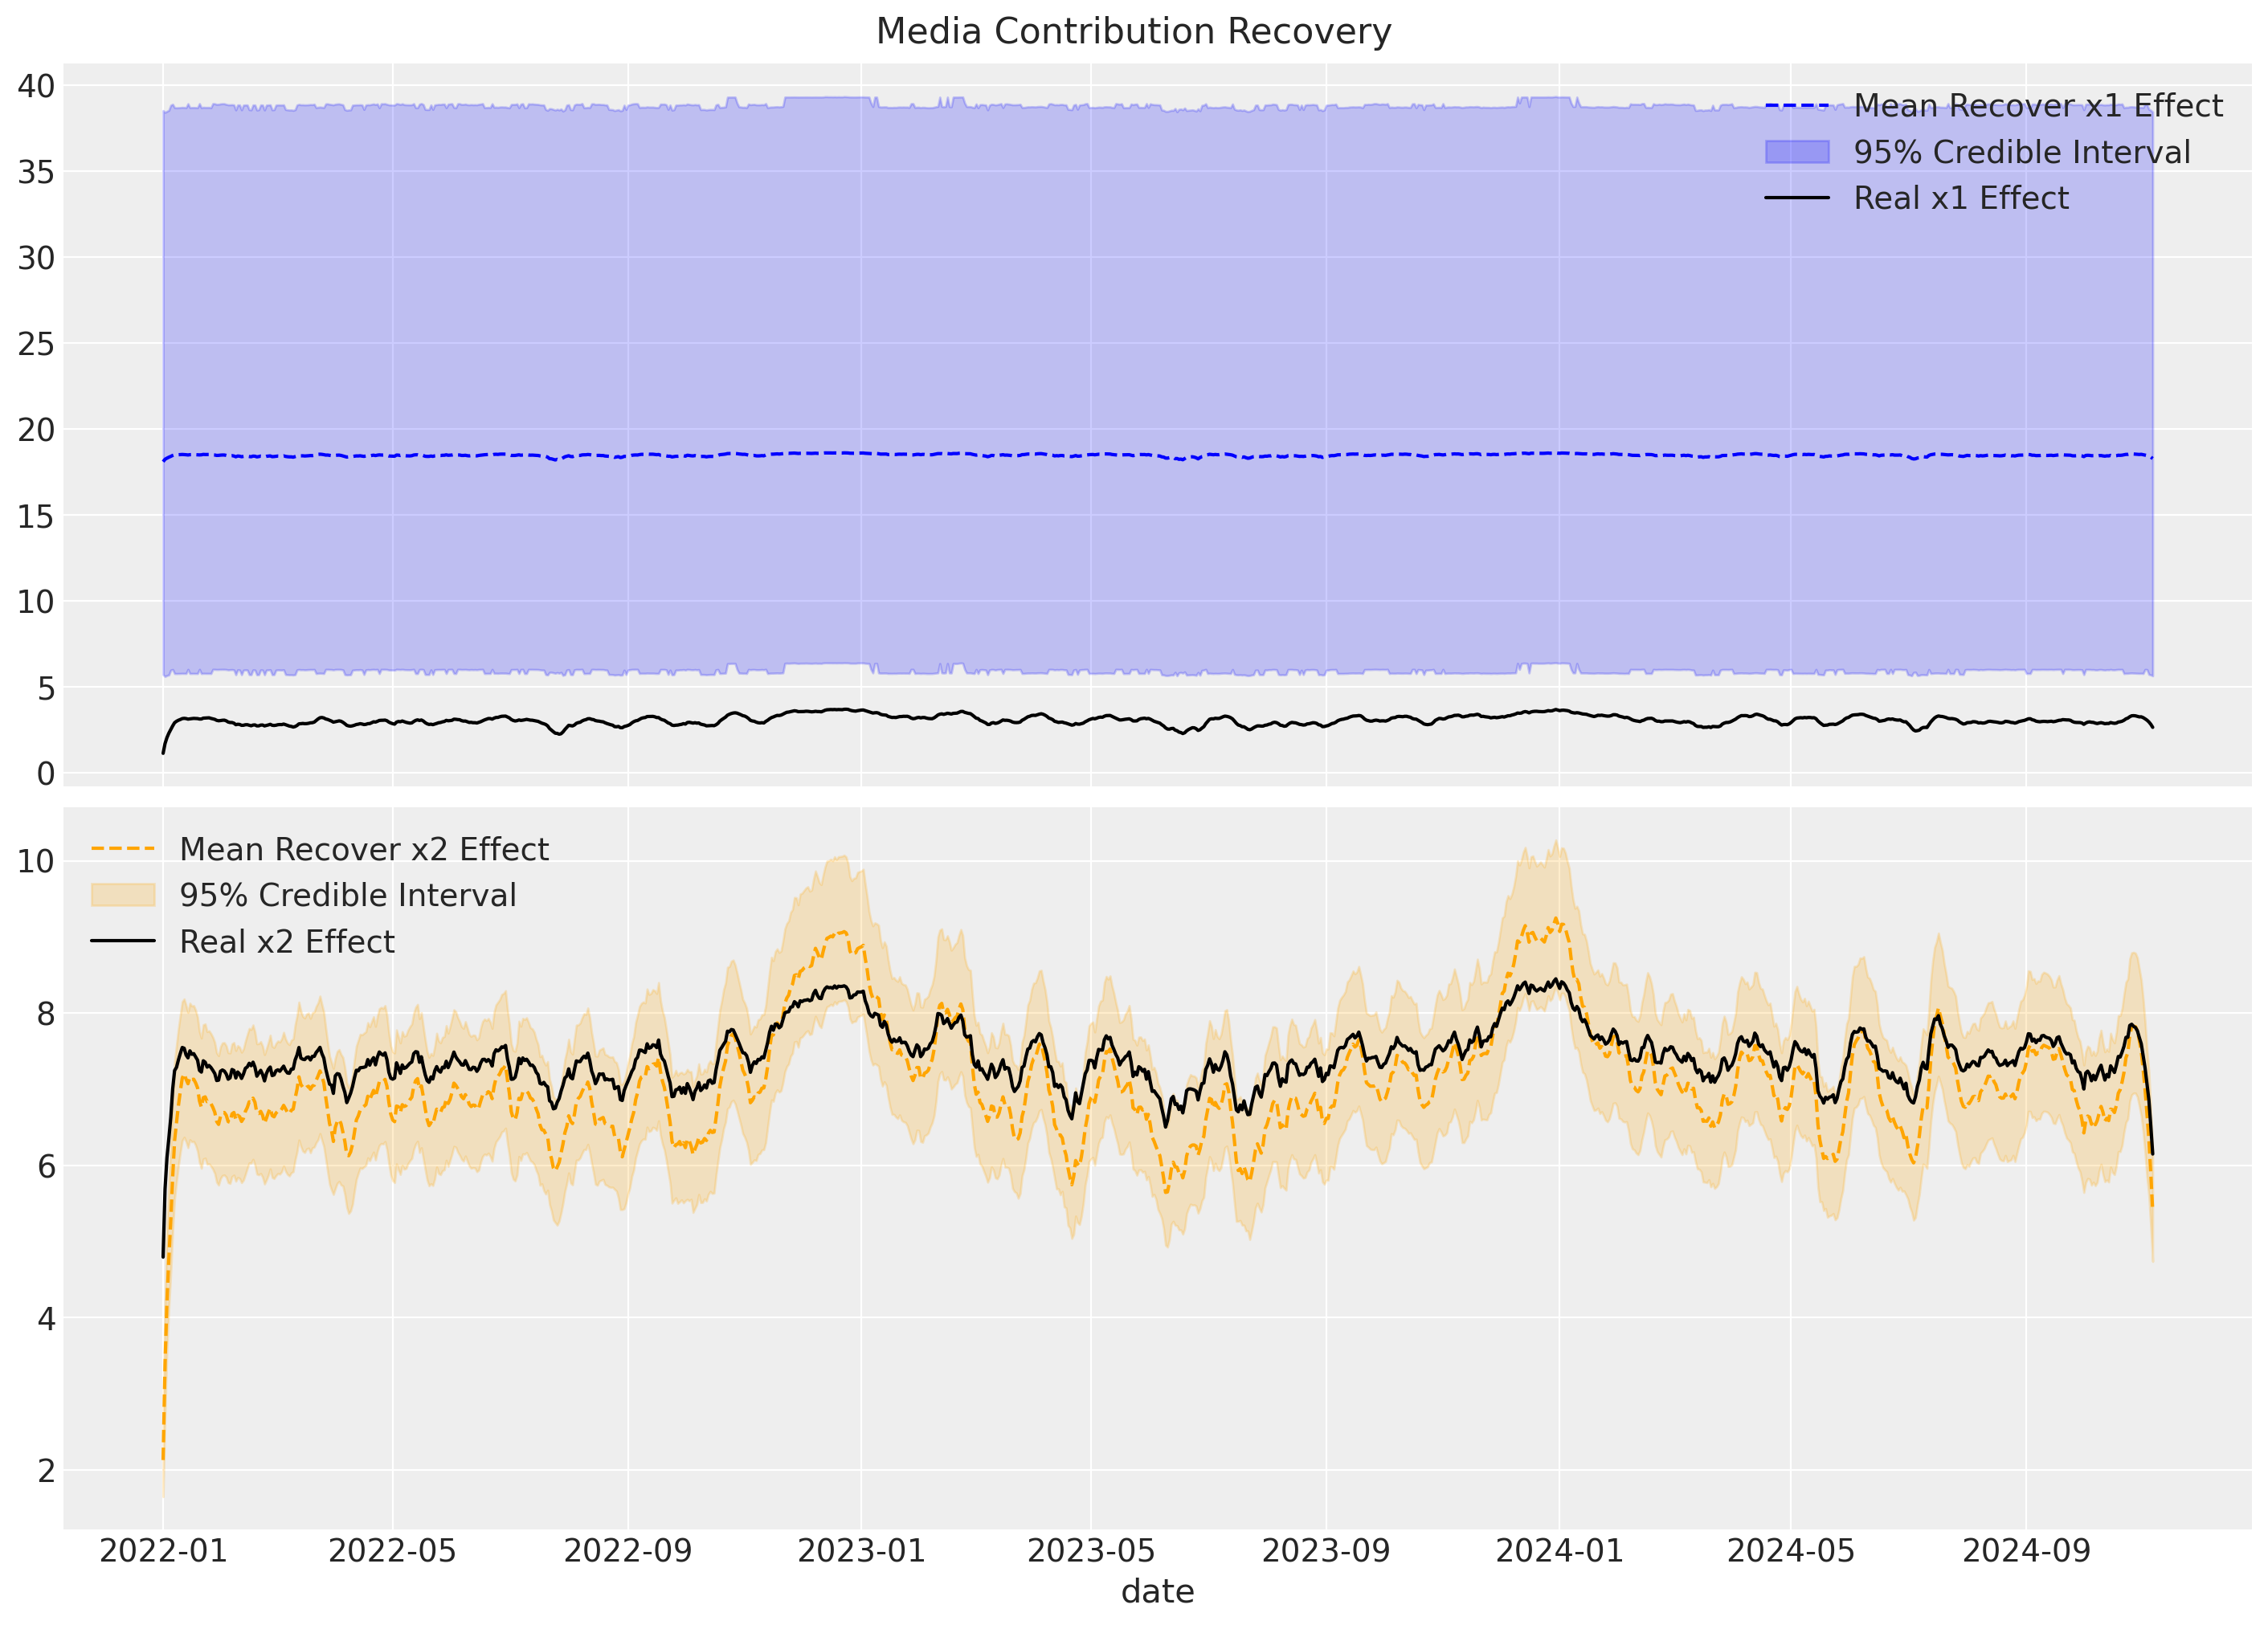

In [32]:
initial_model_recover_effect = az.hdi(initial_causal_mmm.fit_result["channel_contributions"], hdi_prob=0.95) * initial_causal_mmm.target_transformer["scaler"].scale_.item()

fig, ax = plt.subplots(2,1, figsize=(14, 10), sharex=True)

# facebook
ax[0].plot(
    date_range,
    initial_causal_mmm.fit_result.channel_contributions.sel(channel="x1").mean(dim=["chain","draw"]) * initial_causal_mmm.target_transformer["scaler"].scale_.item(),
    label="Mean Recover x1 Effect", linestyle="--", color="blue"
)
ax[0].fill_between(
    date_range,
    initial_model_recover_effect.channel_contributions.isel(hdi=0).sel(channel="x1"),
    initial_model_recover_effect.channel_contributions.isel(hdi=1).sel(channel="x1"),
    alpha=0.2, label="95% Credible Interval", color="blue"
)
ax[0].plot(date_range, df["x1_adstock_saturated"], label="Real x1 Effect", color="black")

# google
ax[1].plot(
    date_range,
    initial_causal_mmm.fit_result.channel_contributions.sel(channel="x2").mean(dim=["chain","draw"]) * initial_causal_mmm.target_transformer["scaler"].scale_.item(),
    label="Mean Recover x2 Effect", linestyle="--", color="orange"
)
ax[1].fill_between(
    date_range,
    initial_model_recover_effect.channel_contributions.isel(hdi=0).sel(channel="x2"),
    initial_model_recover_effect.channel_contributions.isel(hdi=1).sel(channel="x2"),
    alpha=0.2, label="95% Credible Interval", color="orange"
)
ax[1].plot(date_range, df["x2_adstock_saturated"], label="Real x2 Effect", color="black")

# formatting
ax[0].legend()
ax[1].legend()

plt.grid(True)
ax[1].set(xlabel="date")
fig.suptitle("Media Contribution Recovery", fontsize=16)
plt.show()

In [35]:
dag_str = """
digraph {
    x1 -> y;
    x2 -> y;
    x1 -> x2;
    holiday_signal -> y;
    holiday_signal -> x1;
    holiday_signal -> x2;
}
"""

In [36]:
data["holiday_signal"] = holiday_signal
data.head()

date_week         y        x1         x2  holiday_signal  market_growth
0 2022-01-01  6.746401  2.869349   7.491001    5.244234e-45       0.778279
1 2022-01-02  8.171089  3.169818   8.645741    9.276916e-45       0.780413
2 2022-01-03  8.964680  3.479087   9.603749    1.638439e-44       0.782539
3 2022-01-04  9.512757  3.888128  10.347369    2.889097e-44       0.784657
4 2022-01-05  9.933082  4.314848  11.352003    5.086267e-44       0.786768

In [33]:
causal_mmm = MMM(
    sampler_config=sample_kwargs,
    date_column="date_week",
    outcome_node="y",
    adstock=GeometricAdstock(l_max=24),
    saturation=MichaelisMentenSaturation(),
    channel_columns=["x1", "x2"],
    control_columns=["holiday_signal"],
    time_varying_intercept=True,
    dag=dag_str,
)

causal_mmm.model_config["intercept_tvp_config"].ls_mu = 180
causal_mmm.model_config["intercept"] = Prior("Normal", mu=1, sigma=2)

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/pydantic/_internal/_validate_call.py:96: UserWarning: No treatment nodes provided. Using channel columns as treatment nodes.
  res = self.__pydantic_validator__.validate_python(pydantic_core.ArgsKwargs(args, kwargs))
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/dowhy/causal_model.py:582: UserWarning: 4 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [34]:
causal_mmm.adjustment_set, causal_mmm.minimal_adjustment_set

(['holiday_signal'], ['holiday_signal', 'x1', 'x2'])

In [35]:
X = data.drop("y", axis=1)
y = data["y"]

In [36]:
causal_mmm.fit(X=X, y=y, target_accept=0.95, random_seed=rng)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

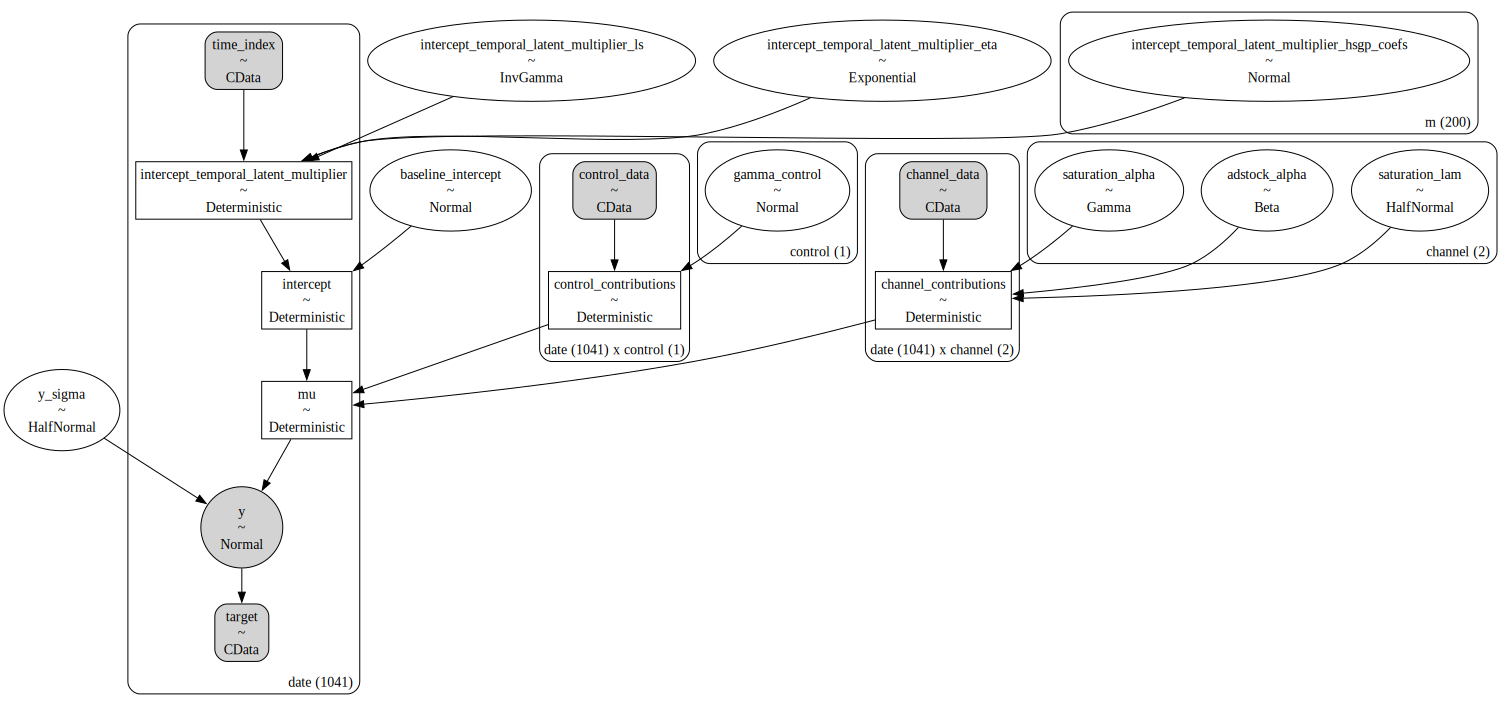

In [37]:
pm.model_to_graphviz(model=causal_mmm.model)

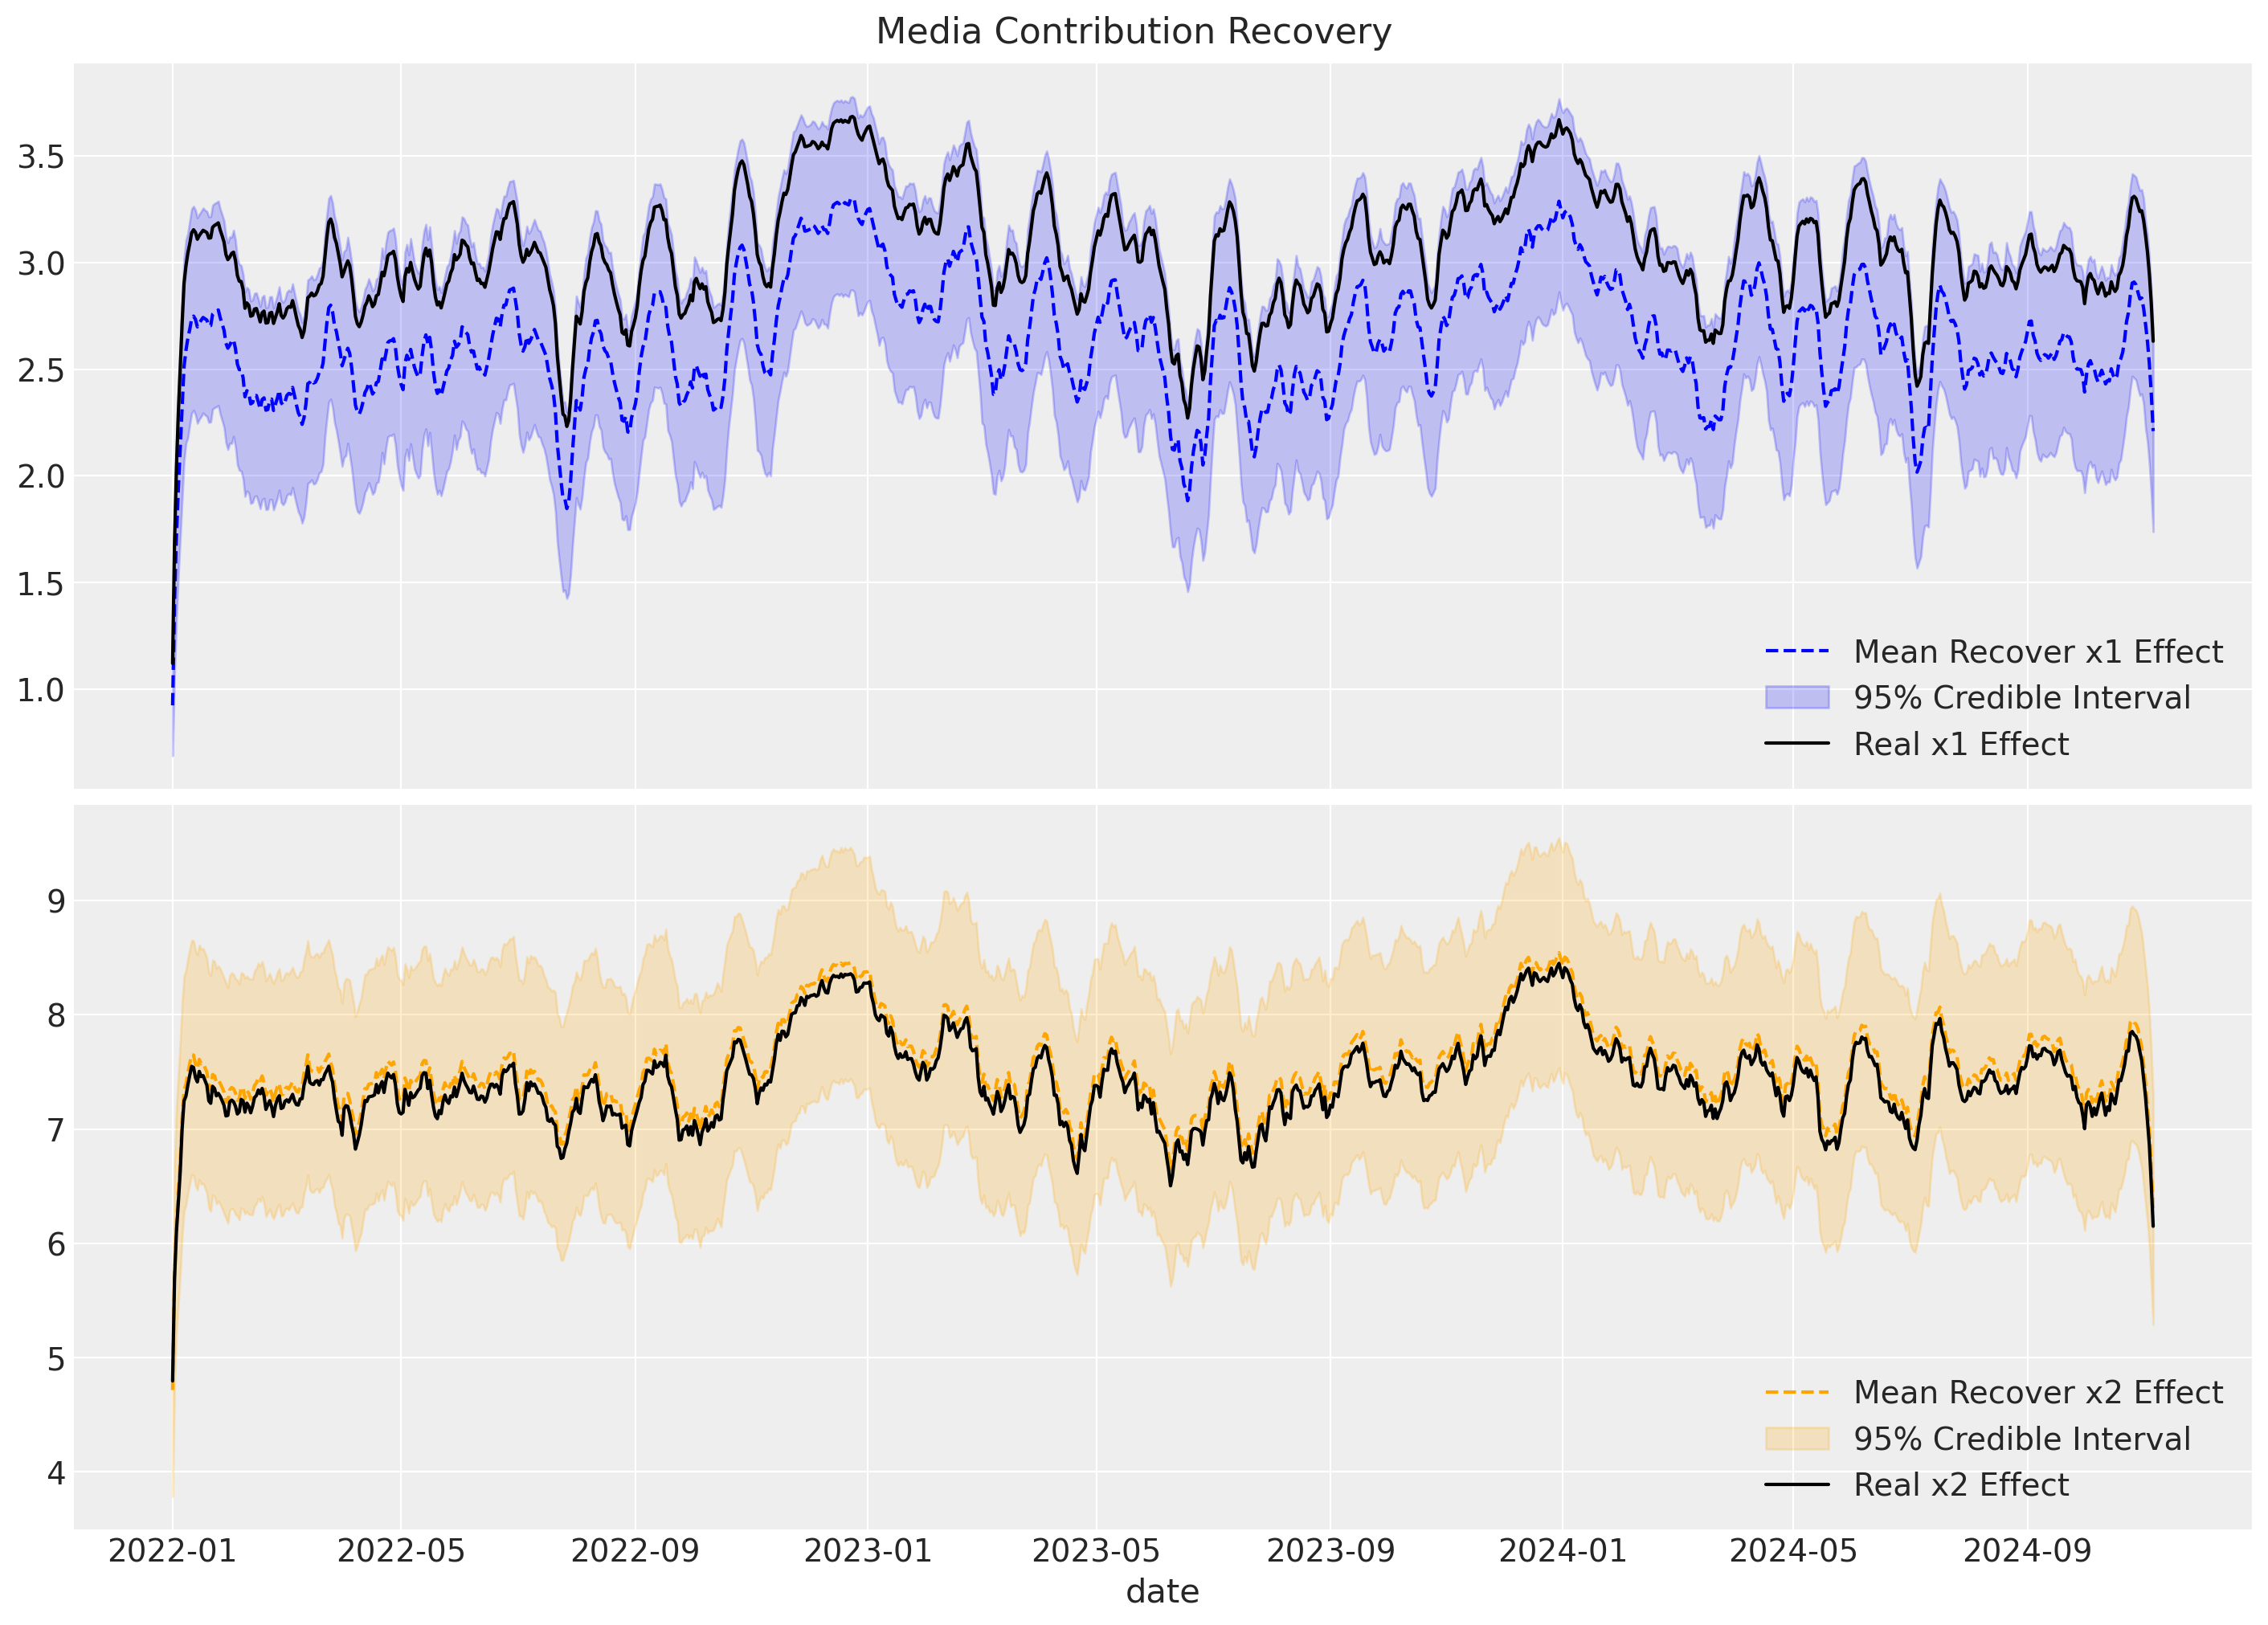

In [38]:
initial_model_recover_effect = az.hdi(causal_mmm.fit_result["channel_contributions"], hdi_prob=0.95) * causal_mmm.target_transformer["scaler"].scale_.item()

fig, ax = plt.subplots(2,1, figsize=(14, 10), sharex=True)

# facebook
ax[0].plot(
    date_range,
    causal_mmm.fit_result.channel_contributions.sel(channel="x1").mean(dim=["chain","draw"]) * causal_mmm.target_transformer["scaler"].scale_.item(),
    label="Mean Recover x1 Effect", linestyle="--", color="blue"
)
ax[0].fill_between(
    date_range,
    initial_model_recover_effect.channel_contributions.isel(hdi=0).sel(channel="x1"),
    initial_model_recover_effect.channel_contributions.isel(hdi=1).sel(channel="x1"),
    alpha=0.2, label="95% Credible Interval", color="blue"
)
ax[0].plot(date_range,df["x1_adstock_saturated"], label="Real x1 Effect", color="black")

# google
ax[1].plot(
    date_range,
    causal_mmm.fit_result.channel_contributions.sel(channel="x2").mean(dim=["chain","draw"]) * causal_mmm.target_transformer["scaler"].scale_.item(),
    label="Mean Recover x2 Effect", linestyle="--", color="orange"
)
ax[1].fill_between(
    date_range,
    initial_model_recover_effect.channel_contributions.isel(hdi=0).sel(channel="x2"),
    initial_model_recover_effect.channel_contributions.isel(hdi=1).sel(channel="x2"),
    alpha=0.2, label="95% Credible Interval", color="orange"
)
ax[1].plot(date_range, df["x2_adstock_saturated"], label="Real x2 Effect", color="black")

# formatting
ax[0].legend()
ax[1].legend()

plt.grid(True)
ax[1].set(xlabel="date")
fig.suptitle("Media Contribution Recovery", fontsize=16)
plt.show()

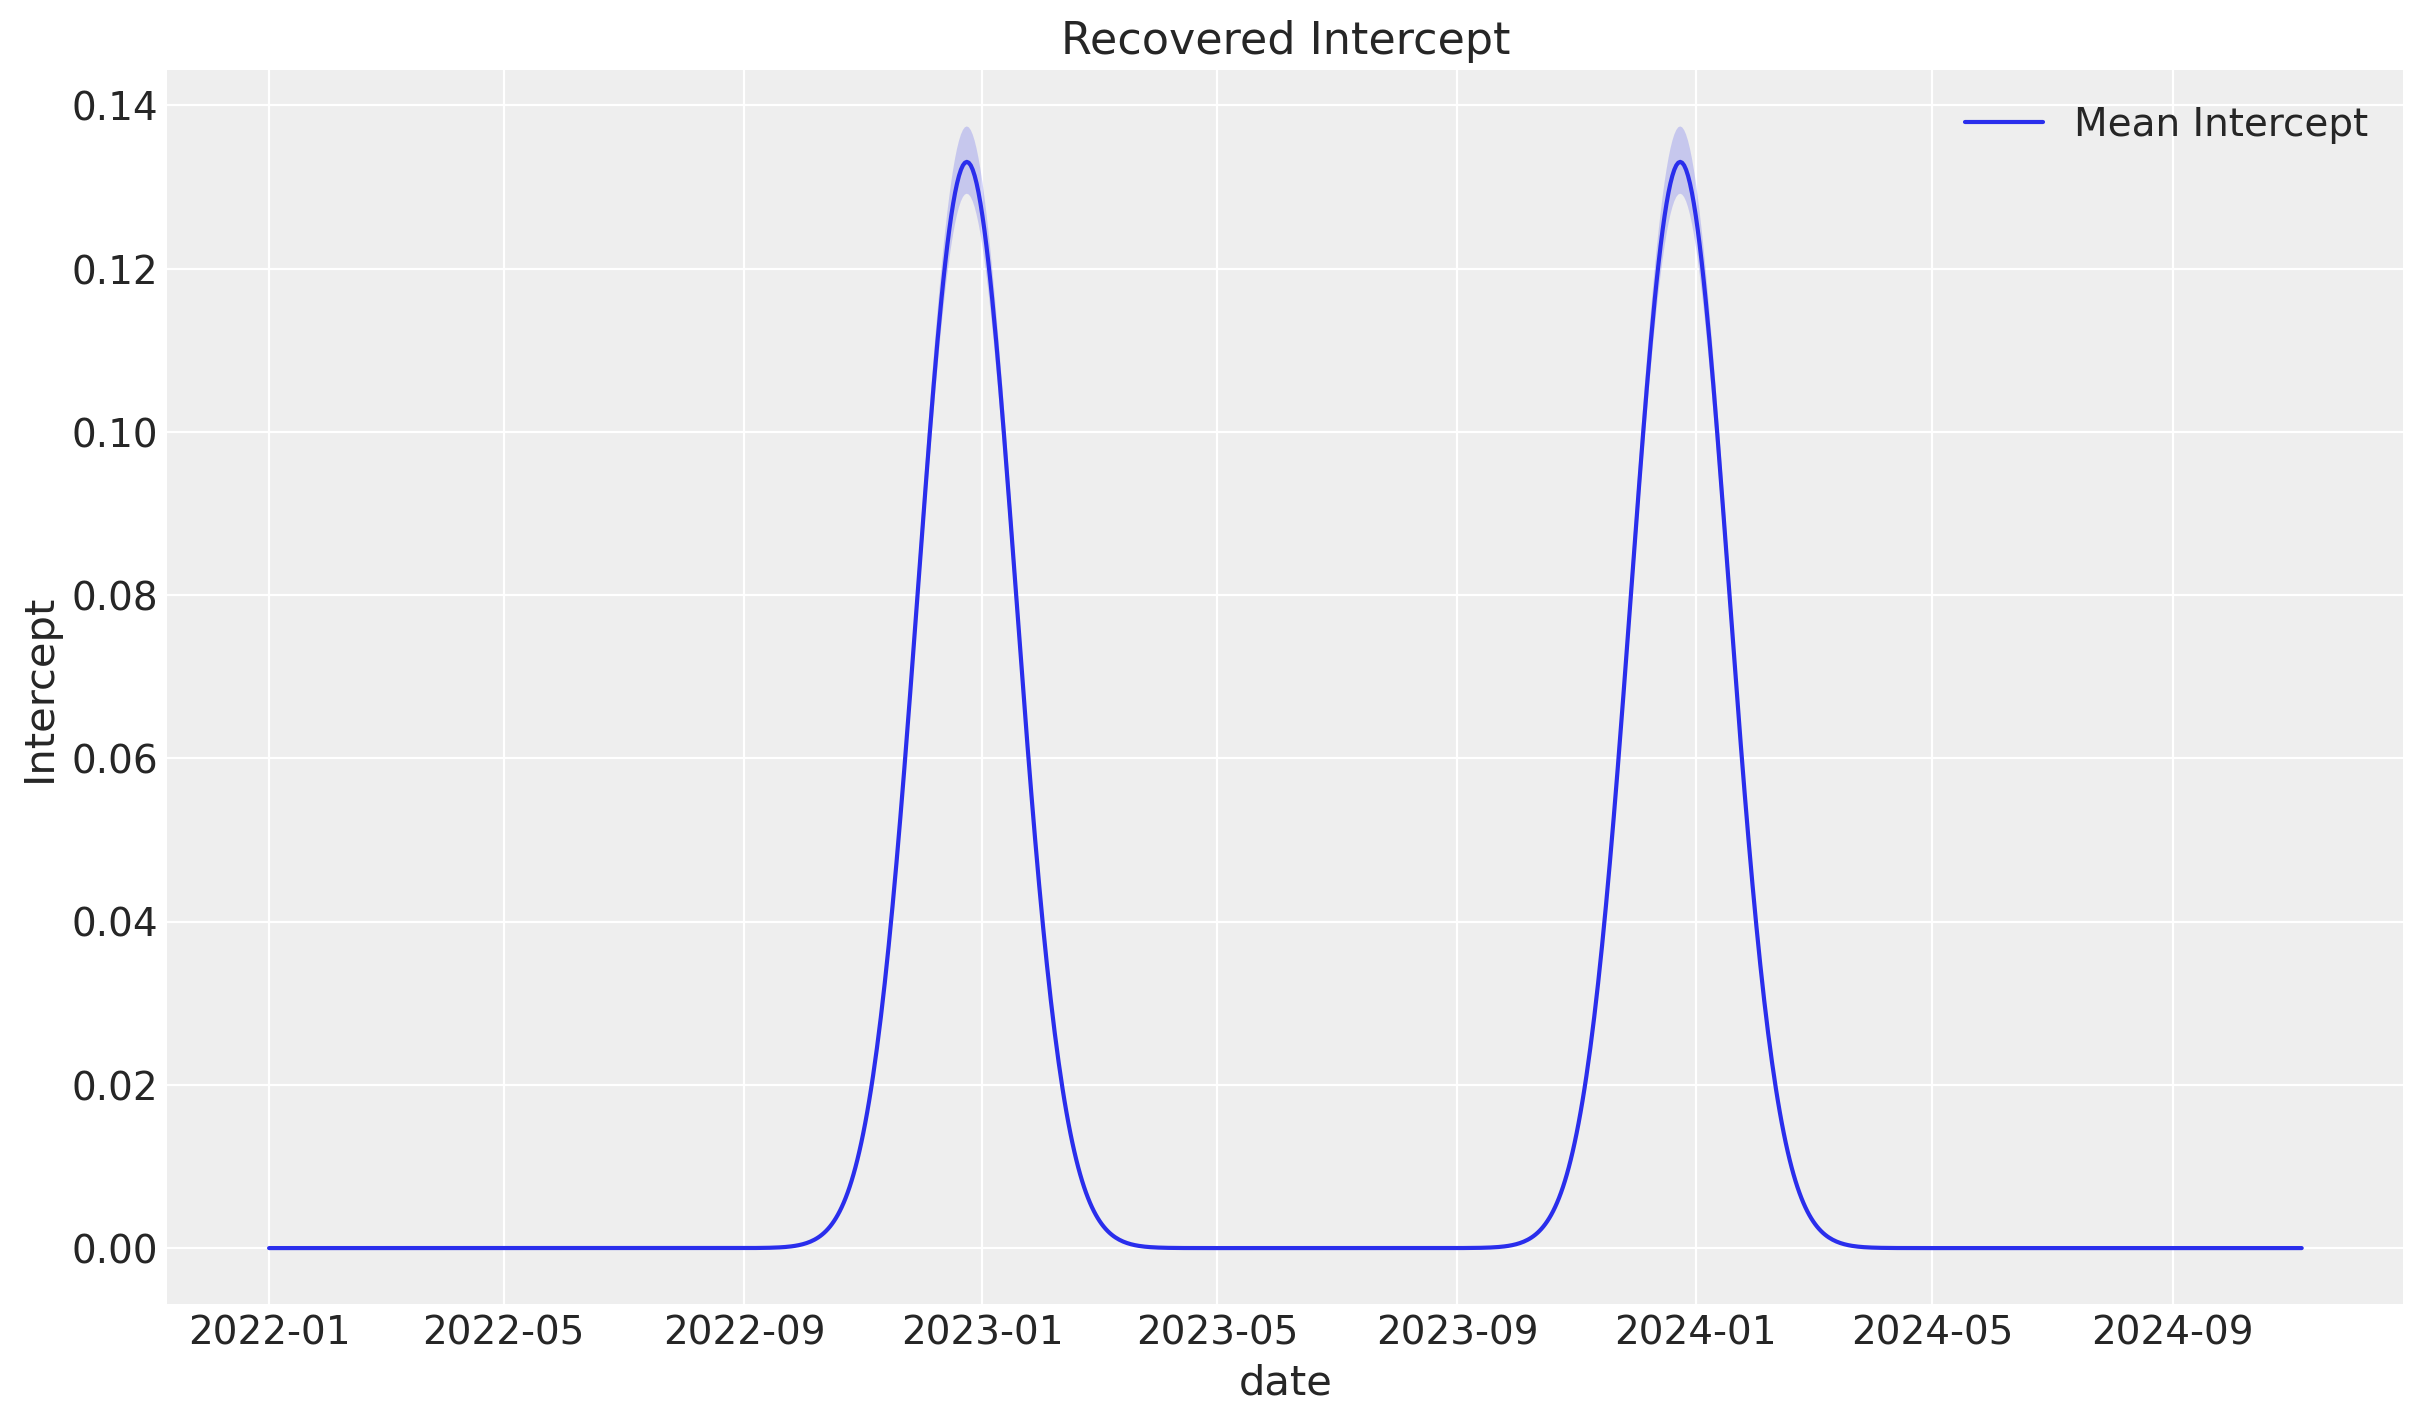

In [39]:
# plot recover intercept
intercept_effect = az.hdi(causal_mmm.fit_result["control_contributions"], hdi_prob=0.95)
mean_intercept = causal_mmm.fit_result.control_contributions.sum(dim=["control"]).mean(dim=["chain","draw"])

fig, ax = plt.subplots()
sns.lineplot(x=date_range, y=mean_intercept, label="Mean Intercept")
ax.fill_between(date_range, intercept_effect.control_contributions.isel(hdi=0).sum(dim=["control"]), intercept_effect.control_contributions.isel(hdi=1).sum(dim=["control"]), alpha=0.2, label="95% Credible Interval")
ax.set(title="Recovered Intercept", xlabel="date", ylabel="Intercept")
plt.show()

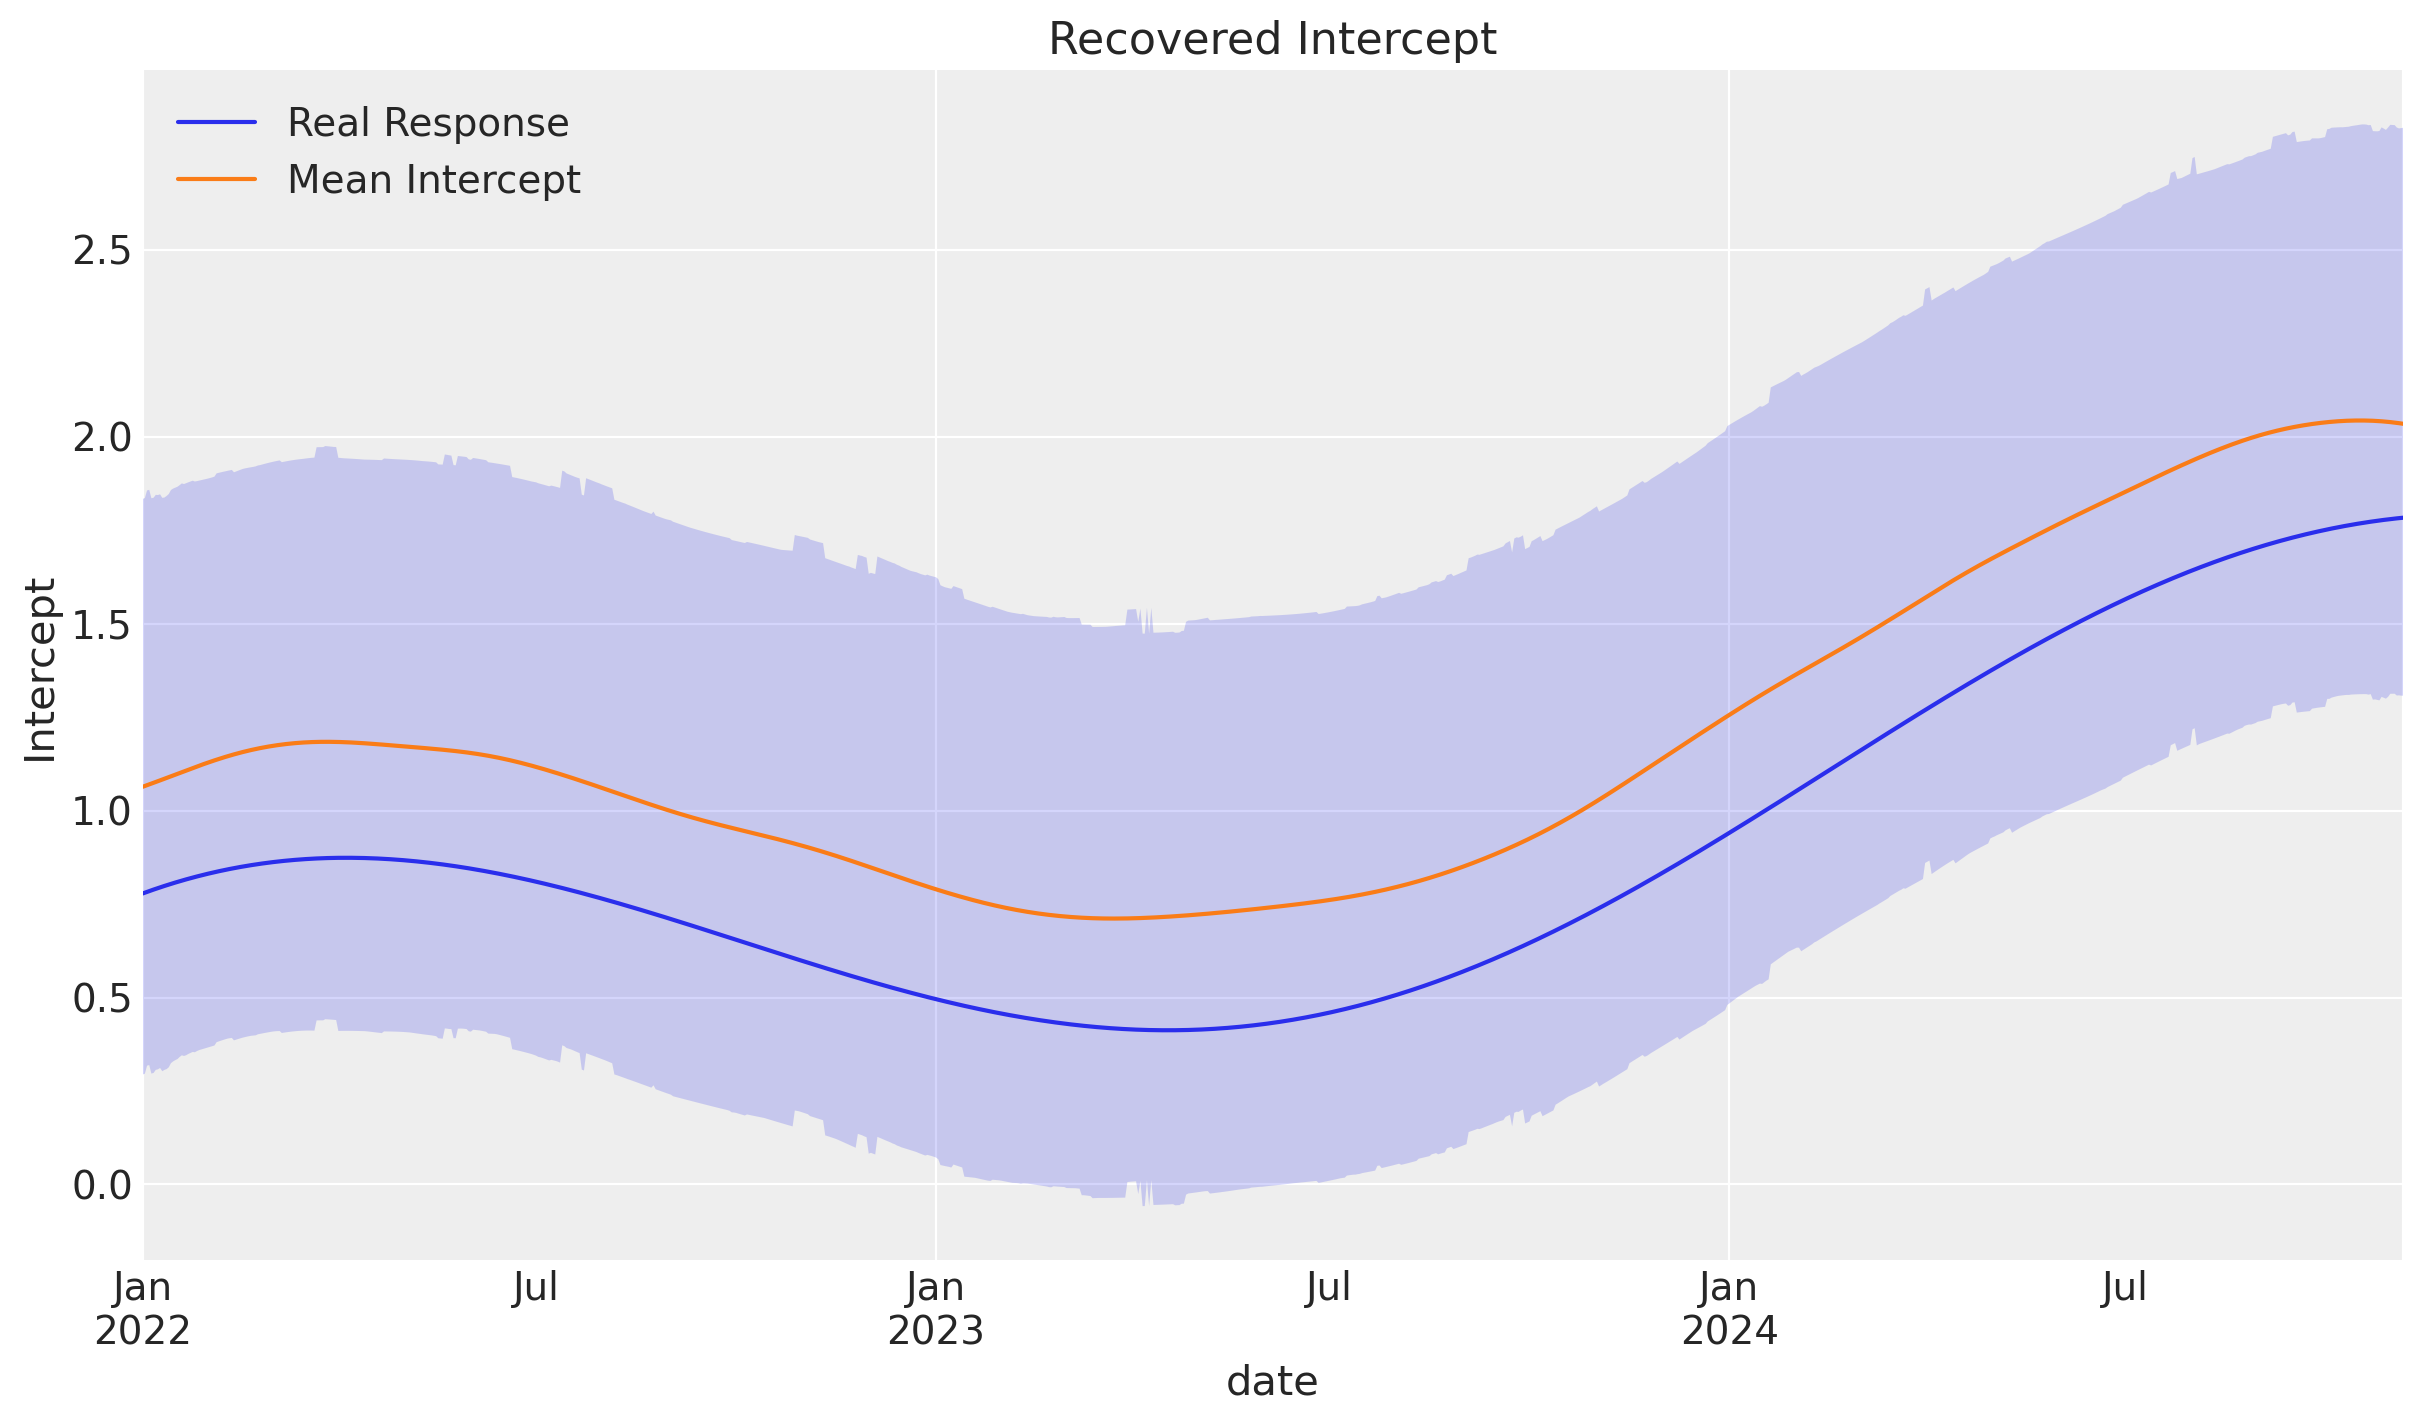

In [40]:
# plot recover intercept
intercept_effect = az.hdi(causal_mmm.fit_result["intercept"], hdi_prob=0.95) * causal_mmm.target_transformer["scaler"].scale_.item()
mean_intercept = causal_mmm.fit_result.intercept.mean(dim=["chain","draw"]) * causal_mmm.target_transformer["scaler"].scale_.item()

fig, ax = plt.subplots()
(df.set_index("date_week")["intercept"] + df.set_index("date_week")["market_growth"] - df.set_index("date_week")["competitor_offers"]).plot(ax=ax, label="Real Response")
sns.lineplot(x=date_range, y=mean_intercept, label="Mean Intercept")
ax.fill_between(date_range, intercept_effect.intercept.isel(hdi=0), intercept_effect.intercept.isel(hdi=1), alpha=0.2, label="95% Credible Interval")
ax.set(title="Recovered Intercept", xlabel="date", ylabel="Intercept")
plt.show()